In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')
from sklearn.model_selection import train_test_split

In [2]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [3]:
sns.set_context('poster')
sns.set_style('white')

In [4]:
ppallete = 'RdYlGn'#'YlGn_d' #"BuGn_d"
porder = ['MED4',  'MIT9312','MIT0604', 'Natl2A', 'MIT9313']
ppallete = [ '#62A586', '#face6e','#f79934', '#7A9BC8', '#F47681', ]
# #ffd7a1
    
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
amarkers = ['X', 'P', 's', 'D', 'o']
aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'
e2_color= '#f2f2f2'
eallorder= ['e1','e2', 'e3', 'e4', 'e5', 'e6']
eallpallete = ['#6cf0ba', '#f2f2f2', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']

efcmorder= ['e1','e2', 'e4', 'e5', ]
efcmpallete = ['#6cf0ba', '#f2f2f2',  '#eeb7cb', '#b9d2d8',]

espallete = ['#6cf0ba', '#D55282', '#538B9B']
#  604 #FCC479
#     #ffd7a1
#     #fcb14c
#     MED4 = #62A586
#     9313 #F47681
#     natl #7A9BC8

In [5]:
ppallete = 'RdYlGn'#'YlGn_d' #"BuGn_d"
porder = ['MED4',  'MIT9312','MIT0604', 'Natl2A', 'MIT9313']
ppallete = [ '#62A586', '#face6e','#f79934', '#7A9BC8', '#F47681', ]
psizes = [150,120,200,120,350]
pmarkers = ['o', 's', '^', 'D', '*']

# #ffd7a1
    
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
amarkers = ['P', 'X', 'h', '<','>']
apallete = ['#6dad36', '#c7e89f', '#f5c4e1', '#d5579d', '#8a0850']

aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'

espallete = ['#6cf0ba', '#D55282', '#538B9B']

In [6]:
df = pd.read_pickle('CCPA.pkl.gz')
df.loc[df.PRO == 'C9B', 'PRO'] = 'MIT0604'

In [7]:
fcmdflist=list()
for i in os.listdir('fcmfiles'):
    if i.endswith('.csv'):
        d = pd.read_csv(os.path.join('fcmfiles', i))
        n = os.path.splitext(i)[0]
        _, experiment, day = n.split('_')
        d['experiment'] = experiment
        d['day'] = day.replace('Days','')
        fcmdflist.append(d)
fcmdf = pd.concat(fcmdflist)
fcmdf.loc[fcmdf.PRO == 'C9B', 'PRO'] = 'MIT0604'
fcmdf['day'] = pd.to_numeric(fcmdf['day'])

In [8]:
fl2cell_model, compdf = cp.gen_FL2cells_model()
df['cells'] = cp.compute_FL2cells(df['FL'], fl2cell_model)
df['logcells'] = np.log(df['cells'])

                            OLS Regression Results                            
Dep. Variable:                    FCM   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     776.5
Date:                Wed, 13 May 2020   Prob (F-statistic):           2.49e-90
Time:                        11:00:17   Log-Likelihood:                -6527.3
No. Observations:                 347   AIC:                         1.306e+04
Df Residuals:                     345   BIC:                         1.307e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.769e+05   3.27e+06     -0.177      0.8

C:\Users\wosnat\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [9]:
def calculate_lag(d):
    minday_fl_threshold = 0.1
    r2_threshold = 0.9

    d = d.reset_index(drop=True)
    maxindex = d.FL.idxmax()
    maxday = d.loc[maxindex]['day']
    minday = d.loc[(d.day < maxday) & (d.FL <= minday_fl_threshold), 'day'].max()
    if minday is np.NaN:
        minday = d.day.min()
    
    minday = min(maxday-7,minday)
    
    reg, intercept, coef, r2 = cp.fit_regression(d.loc[(d.day > minday) & 
                                                       (d.day <= maxday)], 'day', 'logcells')
                        
    L = maxday - ((d.loc[maxindex]['logcells'] - d.loc[0]['logcells']) / coef)
    return pd.Series({
        'maxday' : maxday,
        'minday' : minday,
        'maxlogcells' : d.loc[maxindex]['logcells'],
        'maxcells' : d.loc[maxindex]['cells'],
        'logcells0' : d.loc[0]['logcells'],
        'log10cells0' : np.log10(d.loc[0]['cells']),
        'intercept': intercept,
        'coef': coef,
        'r2': r2,
        'L' : L,
    })

def get_prev_max_day_df(d, minmaxday_threshold):
    d = d.reset_index(drop=True)
    maxindex = d.FL.idxmax()
    maxday = d.loc[maxindex]['day']
    maxdaysdf = d.loc[(d.FL > d.FL.shift()) & (d.FL > d.FL.shift(-1)) & 
                    (d.day < maxday)].reset_index(drop=True)
    if maxdaysdf.shape[0] > 0:
        newmaxindex = maxdaysdf.FL.idxmax()
        newmaxday = maxdaysdf.loc[newmaxindex]['day']

        if ((newmaxday is not np.NaN) and #(newmaxday >= minmaxday_threshold) and 
            (d.loc[d.day == newmaxday, 'FL'].max() > (d.FL.max() / 2))):
            df_prevmax = d.loc[d.day < newmaxday]
            return df_prevmax
    return None

def get_no_outlier_df(d, minday_fl_threshold):
    d_no_outlier = d.loc[(d.FL > minday_fl_threshold) | 
                         (d.FL.shift() < minday_fl_threshold*2) |
                         (d.FL.shift(-1) < minday_fl_threshold*2)
                        ]
    return d_no_outlier

def get_without_max_df(d):
    d = d.reset_index(drop=True)
    maxindex = d.FL.idxmax()
    maxday = d.loc[maxindex]['day']
    d_withoutmaxday = d.loc[d.day < maxday]
    return d_withoutmaxday

def get_df_list(d, minday_fl_threshold, minmaxday_threshold):
    dnomax = get_without_max_df(d)
    dnomax2 = get_without_max_df(dnomax)
    
    df_list = [d, dnomax, dnomax2]
    df_list.extend([get_no_outlier_df(x, minday_fl_threshold) for x in df_list])
    return df_list

def calculate_lag_wrap(d):
    minday_fl_threshold = 0.07
    minmaxday_threshold = 4
    df_list = get_df_list(d, minday_fl_threshold, minmaxday_threshold)
    d2 = get_prev_max_day_df(d,minmaxday_threshold)
    if d2 is not None:
        df_list.extend(get_df_list(d2, minday_fl_threshold, minmaxday_threshold))
    reslist = [calculate_lag(x) for x in df_list]

    sorted_reslist = sorted(reslist, key=lambda x : x['r2'], reverse=True)
    return sorted_reslist[0]           

In [10]:
def computeL(maxday, maxlogcells, logcells0, coef):
    L = maxday - ((maxlogcells - logcells0) / coef)
    return L


In [11]:
def computeMaxDay(maxlogcells, logcells0, coef, L):
    maxday = ((maxlogcells - logcells0) / coef) + L
    return maxday


In [12]:
df = df.loc[~df.experiment.isin(['e7'])]

In [13]:
lagsdf = df.groupby(['experiment', 'sample', 'PRO', 'ALT', 'culture', 'experiment_sample']).apply(calculate_lag_wrap)\
        .reset_index()

In [14]:
lagsdf.head()

experiment sample      PRO  ALT     culture experiment_sample     maxday  \
0         e1    10A  MIT0604   DE  Co_Culture           e1, 10A  13.694444   
1         e1    10B  MIT0604   DE  Co_Culture           e1, 10B  14.960417   
2         e1    10C  MIT0604   DE  Co_Culture           e1, 10C  14.960417   
3         e1    11A     MED4  DE1  Co_Culture           e1, 11A  10.603472   
4         e1    11B     MED4  DE1  Co_Culture           e1, 11B  13.694444   

     minday  maxlogcells      maxcells  logcells0  log10cells0  intercept  \
0  0.715972    19.037963  1.853882e+08  14.244403     6.186266  14.626898   
1  0.715972    19.107290  1.986966e+08  14.013287     6.085893  14.571737   
2  0.000000    19.115056  2.002457e+08  14.373296     6.242243  14.604112   
3  0.000000    18.447188  1.026862e+08  15.371426     6.675725  14.862117   
4  0.000000    19.184498  2.146455e+08  15.584693     6.768346  15.006562   

       coef        r2         L  
0  0.313703  0.993199 -1.586110  
1  0.314278  0.982713 -1.248146  
2  0.311066  0.991391 -0.283185  
3  0.339805  0.997146  1.551911  
4  0.303269  0.998574  1.824440

In [15]:
lagsdf.columns

Index(['experiment', 'sample', 'PRO', 'ALT', 'culture', 'experiment_sample',
       'maxday', 'minday', 'maxlogcells', 'maxcells', 'logcells0',
       'log10cells0', 'intercept', 'coef', 'r2', 'L'],
      dtype='object')

In [16]:
lagsdf = lagsdf.loc[~lagsdf.experiment.isin(['e7'])]

In [17]:
fcmdf.head()

PRO  ALT sample         PRO.1         ALT.1 experiment  day
0     MED4  1A3     1A  7.485642e+06  2.992351e+07       exp1  100
1     MED4  1A3     1B  6.720907e+06  2.159764e+07       exp1  100
2     MED4  1A3     1C  1.121335e+07  1.742056e+07       exp1  100
3  MIT9313  1A3     2A  1.415617e+06  5.134250e+06       exp1  100
4  MIT9313  1A3     2B  1.018640e+06  4.885134e+06       exp1  100

In [18]:
fcmdf.loc[(fcmdf.experiment == 'exp1') & (fcmdf.day == 60), 'e'] = 'e2'
fcmdf.loc[(fcmdf.experiment == 'exp1') & (fcmdf.day == 100), 'e'] = 'e4'
fcmdf.loc[(fcmdf.experiment == 'exp1') & (fcmdf.day == 140), 'e'] = 'e5'
fdf = fcmdf.dropna(subset=['e'])
fdf.loc[:,'experiment_sample'] = fdf['e'] + ', '+ fdf['sample']
fdf['initialcells'] = fdf['PRO.1']/20
fdf['initiallogcells'] = np.log(fdf['PRO.1']/20)
fdf['initiallog10cells'] = np.log10(fdf['PRO.1']/20)

fdf.head()

C:\Users\wosnat\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\wosnat\Anaconda3\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

PRO  ALT sample         PRO.1         ALT.1 experiment  day   e  \
0     MED4  1A3     1A  7.485642e+06  2.992351e+07       exp1  100  e4   
1     MED4  1A3     1B  6.720907e+06  2.159764e+07       exp1  100  e4   
2     MED4  1A3     1C  1.121335e+07  1.742056e+07       exp1  100  e4   
3  MIT9313  1A3     2A  1.415617e+06  5.134250e+06       exp1  100  e4   
4  MIT9313  1A3     2B  1.018640e+06  4.885134e+06       exp1  100  e4   

  experiment_sample  initialcells  initiallogcells  initiallog10cells  
0            e4, 1A  374282.11585        12.832765           5.573199  
1            e4, 1B  336045.34005        12.725001           5.526398  
2            e4, 1C  560667.50650        13.236883           5.748705  
3            e4, 2A   70780.85640        11.167344           4.849916  
4            e4, 2B   50931.98990        10.838246           4.706991

In [19]:
fdf.columns

Index(['PRO', 'ALT', 'sample', 'PRO.1', 'ALT.1', 'experiment', 'day', 'e',
       'experiment_sample', 'initialcells', 'initiallogcells',
       'initiallog10cells'],
      dtype='object')

In [20]:
lagsdf = pd.merge(lagsdf, fdf[['experiment_sample', 'initialcells', 'initiallogcells',
       'initiallog10cells']], on='experiment_sample', how='left')
lagsdf.loc[lagsdf.experiment == 'e1', 'initiallogcells'] = np.log(1e6)


In [21]:
lagsdf.loc[lagsdf.experiment == 'e1', 'initialcells'] = 1e6
lagsdf.loc[lagsdf.experiment == 'e1', 'initiallog10cells'] = np.log10(1e6)


In [22]:
lagsdf.loc[lagsdf['sample'] == '8C']

experiment sample      PRO ALT     culture experiment_sample     maxday  \
87          e1     8C  MIT9312  DE  Co_Culture            e1, 8C  13.694444   
165         e2     8C  MIT9312  DE  Co_Culture            e2, 8C  11.110000   
240         e3     8C  MIT9312  DE  Co_Culture            e3, 8C  14.000000   
316         e4     8C  MIT9312  DE  Co_Culture            e4, 8C  15.140000   
385         e5     8C  MIT9312  DE  Co_Culture            e5, 8C  36.890000   
455         e6     8C  MIT9312  DE  Co_Culture            e6, 8C  30.590000   

        minday  maxlogcells      maxcells  logcells0  log10cells0  intercept  \
87    0.715972    19.032631  1.844024e+08  13.983972     6.073162  14.897213   
165   3.230000    18.646136  1.252893e+08  14.013287     6.085893  13.694917   
240   7.000000    17.120083  2.723691e+07  13.983972     6.073162   9.846954   
316   8.140000    18.005701  6.603538e+07  13.983972     6.073162  11.258252   
385  29.830000    17.992283  6.515520e+07  13.983972     6.073162   1.672492   
455  20.740000    17.657886  4.663615e+07  13.983972     6.073162   4.873930   

         coef        r2          L  initialcells  initiallogcells  \
87   0.301280  0.994672  -3.062893  1000000.0000        13.815511   
165  0.453820  0.992841   0.901431   811105.9910        13.606154   
240  0.520217  0.999829   7.971536           NaN              NaN   
316  0.449870  0.991991   6.200242   648425.6925        13.382303   
385  0.442149  0.999337  27.824483      335.0000         5.814131   
455  0.416000  0.962017  21.758471           NaN              NaN   

     initiallog10cells  
87            6.000000  
165           5.909078  
240                NaN  
316           5.811860  
385           2.525045  
455                NaN

In [23]:
lagsdf.groupby('experiment')['initiallogcells'].describe().T

experiment            e1         e2   e3         e4         e5   e6
count       9.100000e+01  73.000000  0.0  72.000000  64.000000  0.0
mean        1.381551e+01  13.823901  NaN  12.694245   8.445367  NaN
std         1.786198e-15   0.633059  NaN   1.308090   2.655586  NaN
min         1.381551e+01  12.451996  NaN   5.873385   3.332205  NaN
25%         1.381551e+01  13.498208  NaN  12.528219   6.269816  NaN
50%         1.381551e+01  13.897295  NaN  13.077763   8.268281  NaN
75%         1.381551e+01  14.277954  NaN  13.420939  10.948008  NaN
max         1.381551e+01  15.174508  NaN  14.218358  12.698033  NaN

In [24]:
lagsdf['L_init'] = lagsdf.apply(lambda x: computeL(x['maxday'], x['maxlogcells'], x['initiallogcells'], x['coef']), axis=1)

In [25]:
e1coef_df = lagsdf.loc[lagsdf.experiment == 'e1', ['sample', 'coef', 'L_init'] ]
e1coef_df.index = e1coef_df['sample']

lagsdf['e1 coef'] = lagsdf['sample'].map(e1coef_df['coef'])
lagsdf['e1 L_init'] = lagsdf['sample'].map(e1coef_df['L_init'])


In [26]:
lagsdf['L_init_e1coef'] = lagsdf.apply(
    lambda x: computeL(x['maxday'], x['maxlogcells'], x['initiallogcells'], x['e1 coef']), axis=1)

In [27]:
lagsdf['maxday_e1'] = lagsdf.apply(
    lambda x: computeMaxDay(x['maxlogcells'], x['initiallogcells'], x['e1 coef'], x['e1 L_init']), axis=1)

In [28]:
lagsdf.to_pickle('growth_lag.pkl.gz')

In [29]:
le1df = lagsdf.loc[lagsdf.experiment == 'e1']

In [30]:
le1df.columns

Index(['experiment', 'sample', 'PRO', 'ALT', 'culture', 'experiment_sample',
       'maxday', 'minday', 'maxlogcells', 'maxcells', 'logcells0',
       'log10cells0', 'intercept', 'coef', 'r2', 'L', 'initialcells',
       'initiallogcells', 'initiallog10cells', 'L_init', 'e1 coef',
       'e1 L_init', 'L_init_e1coef', 'maxday_e1'],
      dtype='object')

In [31]:
(le1df.maxday - le1df.maxday_e1).value_counts()

0.000000e+00    89
6.661338e-16     1
8.881784e-16     1
dtype: int64

In [32]:
sns.relplot(data=le1df, x='maxday', y='maxday_e1')

In [33]:
sns.set_context('talk')
sns.set_style('white')


In [34]:
lagsdf.columns

Index(['experiment', 'sample', 'PRO', 'ALT', 'culture', 'experiment_sample',
       'maxday', 'minday', 'maxlogcells', 'maxcells', 'logcells0',
       'log10cells0', 'intercept', 'coef', 'r2', 'L', 'initialcells',
       'initiallogcells', 'initiallog10cells', 'L_init', 'e1 coef',
       'e1 L_init', 'L_init_e1coef', 'maxday_e1'],
      dtype='object')

In [35]:
maxdf = df.groupby(['experiment', 'sample', 'PRO', 'ALT', 'culture', 'experiment_sample'])['cells'].max()\
        .reset_index()

In [36]:
sns.catplot(data=maxdf, x='experiment', y='cells', kind='box', aspect=1.3,
           order=eallorder, palette=eallpallete)
#plt.yscale('log')
plt.title('maximum number of cells')

Text(0.5, 1, 'maximum number of cells')

In [37]:
sns.catplot(data=maxdf, x='experiment', y='cells', kind='box', 
           order=eallorder, palette=eallpallete,
            aspect=0.8, height=5,
            col='PRO', col_order=porder)
plt.suptitle('maximum number of cells', y=1.05)
    

Text(0.5, 1.05, 'maximum number of cells')

In [38]:
from statsmodels.formula.api import ols
for p in porder:
    mod = ols('cells ~ C(experiment)',
                    data=maxdf.loc[maxdf.PRO == p]
             ).fit()
    print(f'-------------------------- {p} ----------------------------')
    print(mod.summary())
    print(sm.stats.anova_lm(mod))
    pair_t = mod.t_test_pairwise("C(experiment)", method='b')
    print(pair_t.result_frame)
    print(f'-------------------------- {p} ----------------------------')
    print(pair_t.result_frame.loc[pair_t.result_frame['reject-b'], 'pvalue-b'])
    #aov_table = sm.stats.anova_lm(mod, typ=2)
    #print(aov_table)

-------------------------- MED4 ----------------------------
                            OLS Regression Results                            
Dep. Variable:                  cells   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     49.70
Date:                Wed, 13 May 2020   Prob (F-statistic):           5.26e-23
Time:                        11:00:40   Log-Likelihood:                -1599.2
No. Observations:                  85   AIC:                             3210.
Df Residuals:                      79   BIC:                             3225.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [39]:
sns.set_style('white')
sns.set_context('talk')

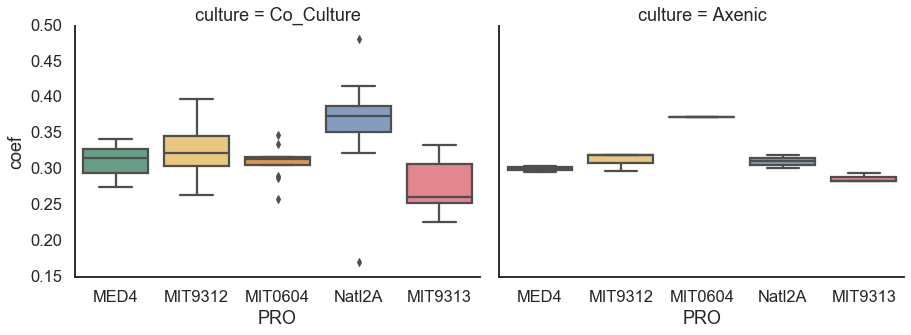

In [40]:
    sns.catplot(data=lagsdf.loc[lagsdf.experiment.isin(['e1']) & lagsdf.culture.isin(['Axenic', 'Co_Culture'])]
                , x='PRO', y='coef', kind='box', aspect=1.3, col='culture',
               order=porder, palette=ppallete)
    #plt.title(i)

In [41]:
    sns.catplot(data=lagsdf.loc[lagsdf.experiment.isin(['e1']) & lagsdf.culture.isin(['Axenic', 'Co_Culture'])]
                , x='PRO', y='maxcells', kind='box', aspect=1.3, col='culture',
               order=porder, palette=ppallete)
    #plt.title(i)

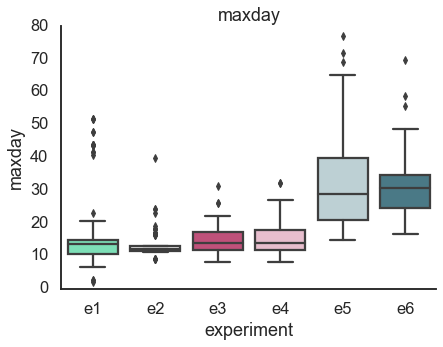

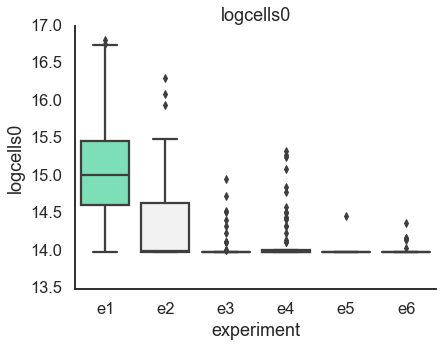

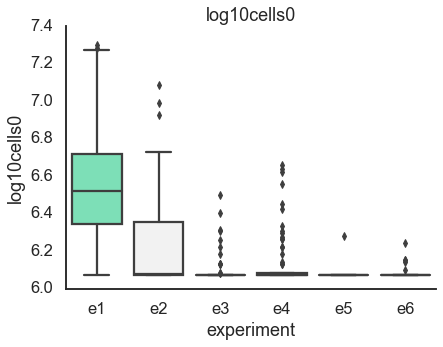

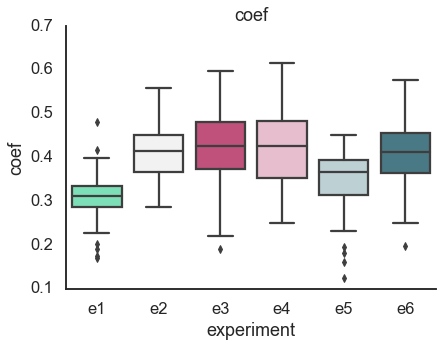

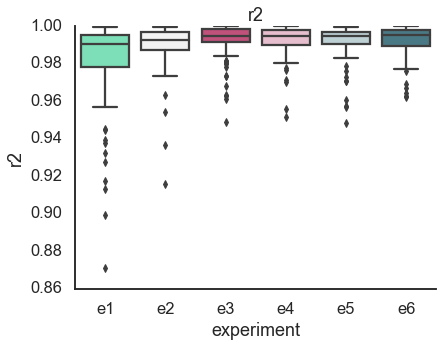

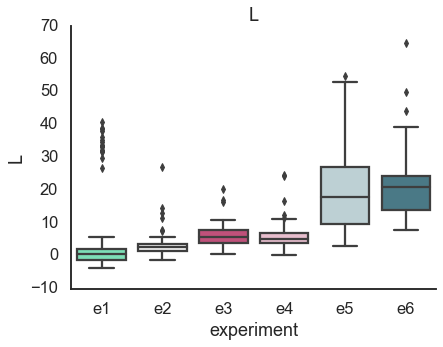

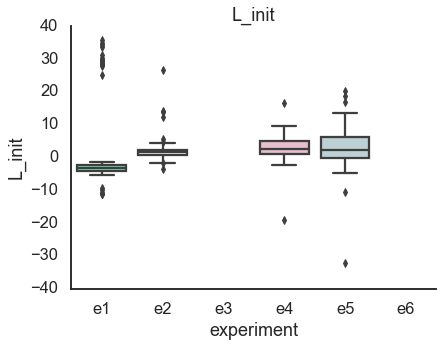

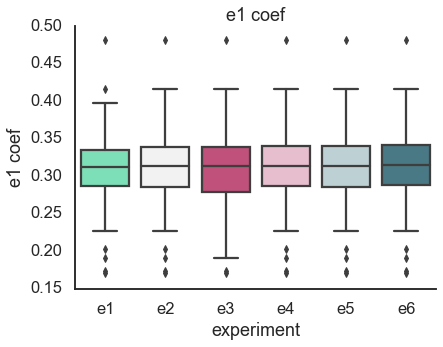

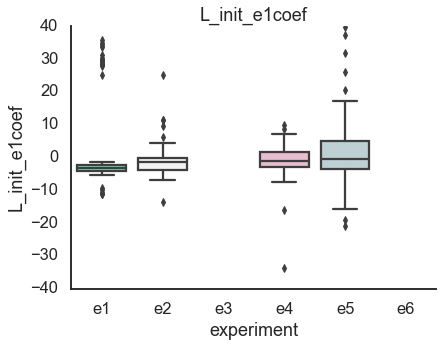

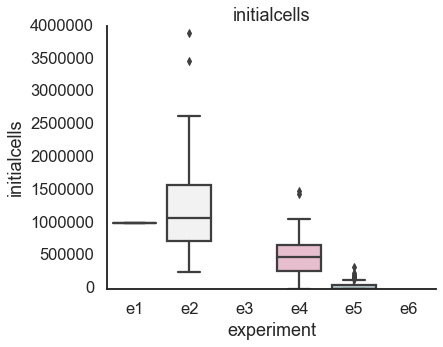

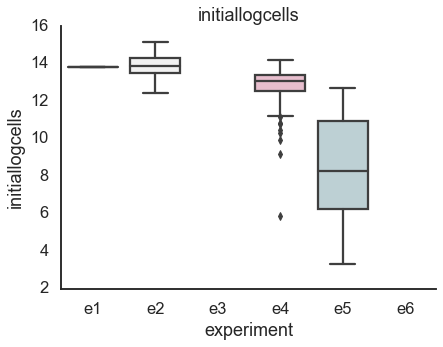

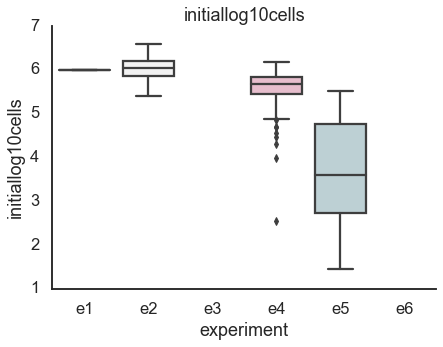

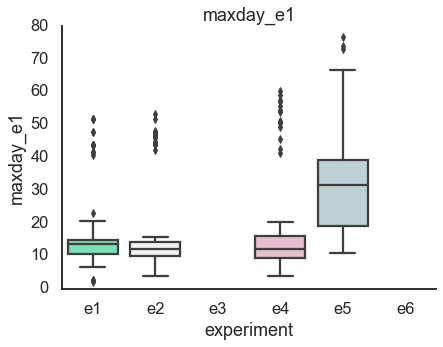

In [42]:
for i in ['maxday', 'maxlogcells', 'logcells0', 'log10cells0', 'intercept', 'coef', 'r2', 'L', 
          'L_init', 'e1 coef','L_init_e1coef', 'initialcells', 'initiallogcells',
       'initiallog10cells', 'maxday_e1']:
    sns.catplot(data=lagsdf, x='experiment', y=i, kind='box', aspect=1.3,
               order=eallorder, palette=eallpallete)
    plt.title(i)

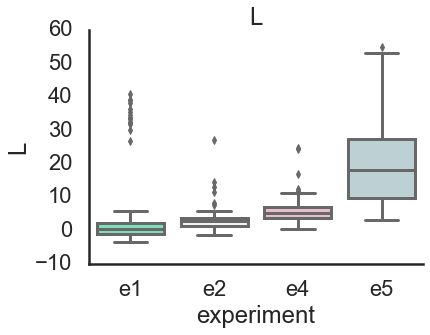

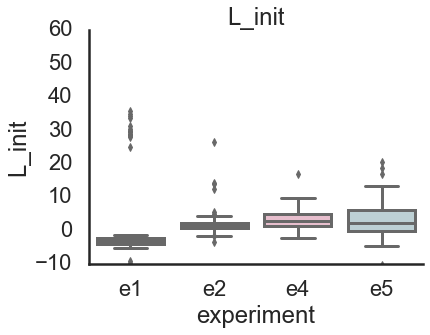

In [43]:
sns.set_style('white')
sns.set_context('poster')
for i in [#'maxday', 'maxlogcells', 'logcells0', 'log10cells0', 'intercept', 'coef', 'r2', 
    'L', 
          'L_init', #'e1 coef','L_init_e1coef', 'initialcells', 'initiallogcells',
       #'initiallog10cells', 'maxday_e1'
]:
    sns.catplot(data=lagsdf, x='experiment', y=i, kind='box', aspect=1.3, 
                order=efcmorder, palette=efcmpallete,
                facet_kws=dict(ylim=(-10,60))
                
               )
    plt.title(i)

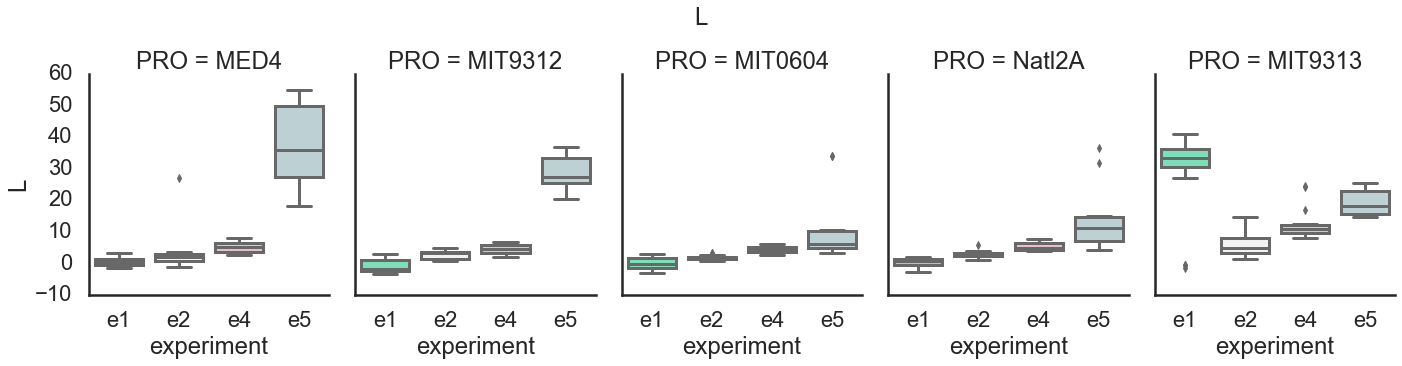

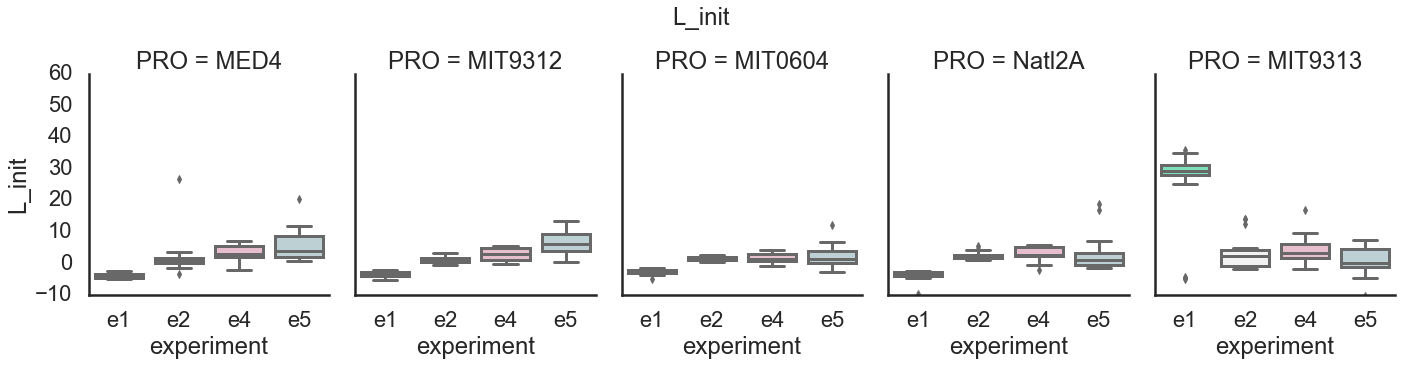

In [44]:
for i in [#'maxday', 'maxlogcells', 'logcells0', 'log10cells0', 'intercept', 'coef', 'r2',
    'L', 
          'L_init', #'e1 coef','L_init_e1coef', 'initialcells', 'initiallogcells',
       #'initiallog10cells', 'maxday_e1'
]:
    sns.catplot(data=lagsdf, x='experiment', y=i, kind='box', aspect=0.8, height=5,
                order=efcmorder,palette=efcmpallete,
                col='PRO', col_order=porder,
                facet_kws=dict(ylim=(-10,60))
               )
    plt.suptitle(i, y=1.05)

In [45]:
from statsmodels.formula.api import ols
for i in ['L', 'L_init', ]:
    for p in porder:
        mod = ols(f'{i} ~ C(experiment)',
                        data=lagsdf.loc[(lagsdf.PRO == p) & lagsdf.experiment.isin(efcmorder)]
                 ).fit()
        print(f'-------------------------- {i} {p} ----------------------------')
        print(mod.summary())
        print(sm.stats.anova_lm(mod))
        pair_t = mod.t_test_pairwise("C(experiment)", method='b')
        print(pair_t.result_frame)
        print(f'-------------------------- {i} {p} ----------------------------')
        print(pair_t.result_frame.loc[pair_t.result_frame['reject-b'], 'pvalue-b'])
        #aov_table = sm.stats.anova_lm(mod, typ=2)
        #print(aov_table)

-------------------------- L MED4 ----------------------------
                            OLS Regression Results                            
Dep. Variable:                      L   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     72.60
Date:                Wed, 13 May 2020   Prob (F-statistic):           6.00e-19
Time:                        11:00:48   Log-Likelihood:                -190.46
No. Observations:                  58   AIC:                             388.9
Df Residuals:                      54   BIC:                             397.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
                 df      sum_sq    mean_sq         F    PR(>F)
C(experiment)   3.0  191.607639  63.869213  4.885628  0.004813
Residual       48.0  627.498119  13.072877       NaN       NaN
           coef   std err         t     P>|t|  Conf. Int. Low  \
e2-e1  4.151929  1.392617  2.981386  0.004496        1.351885   
e4-e1  2.907586  1.392617  2.087857  0.042142        0.107541   
e5-e1  5.011783  1.422387  3.523503  0.000946        2.151884   
e4-e2 -1.244344  1.418172 -0.877428  0.384625       -4.095770   
e5-e2  0.859854  1.447416  0.594062  0.555261       -2.050370   
e5-e4  2.104198  1.447416  1.453762  0.152520       -0.806027   

       Conf. Int. Upp.  pvalue-b  reject-b  
e2-e1         6.951974  0.026978      True  
e4-e1         5.707630  0.252849     False  
e5-e1         7.871683  0.005678      True  
e4-e2         1.607082  1.000000     False  
e5-e2         3.770079  1.000000     F

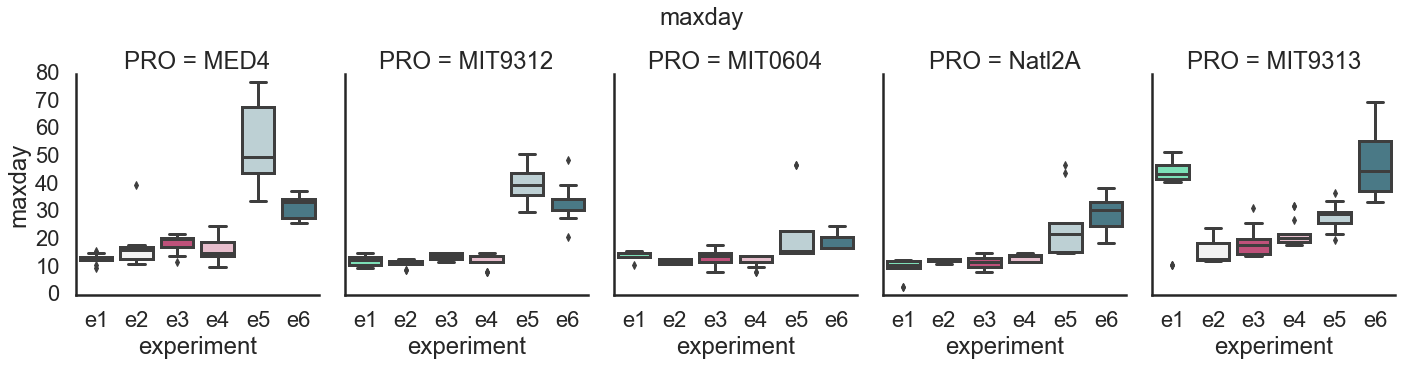

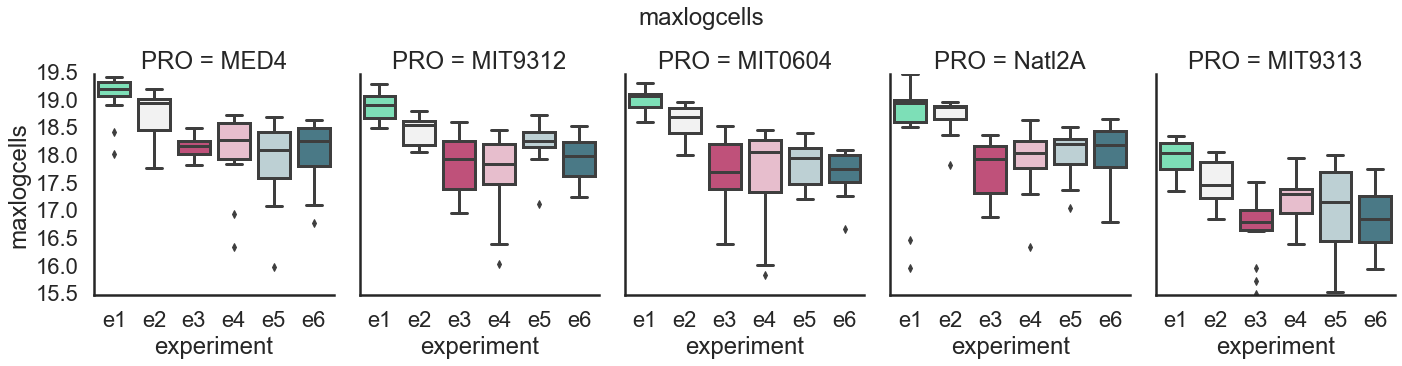

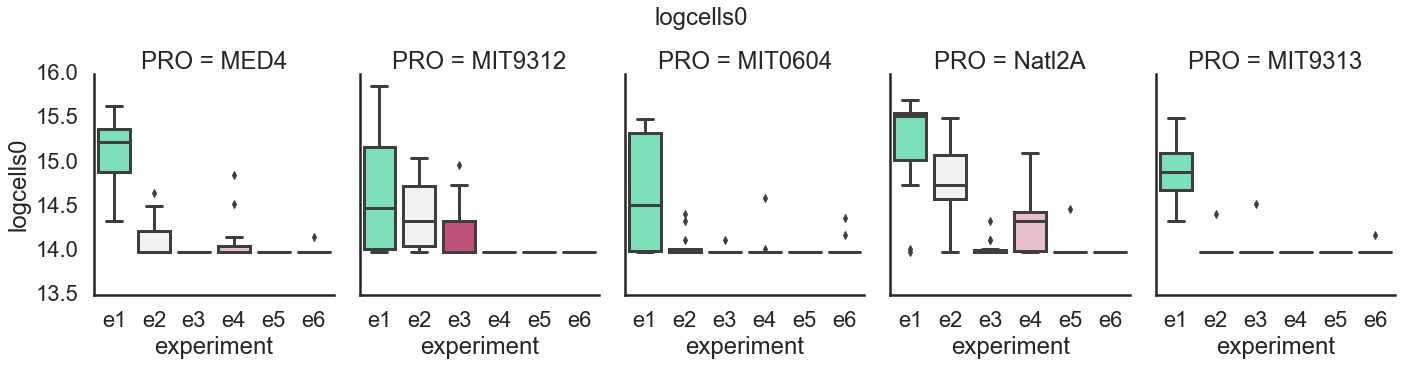

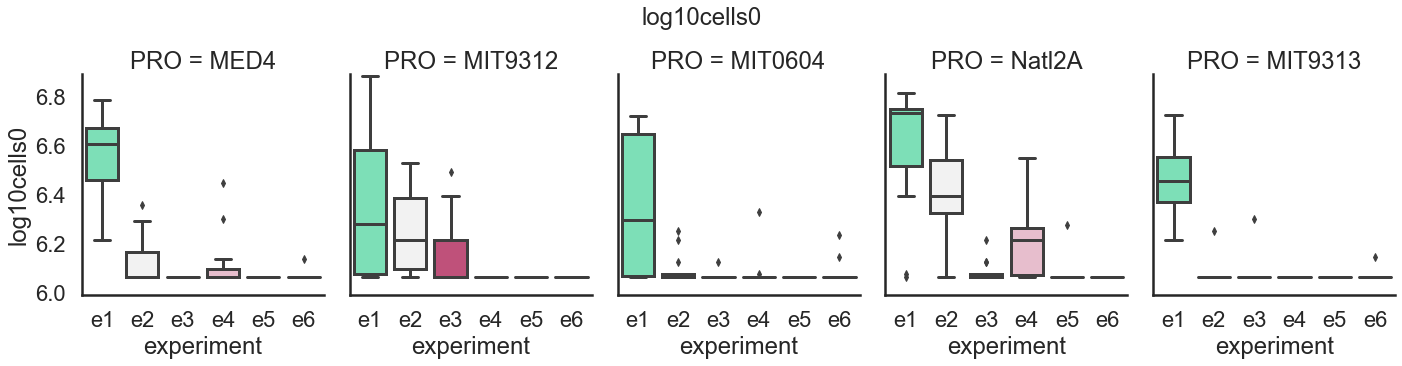

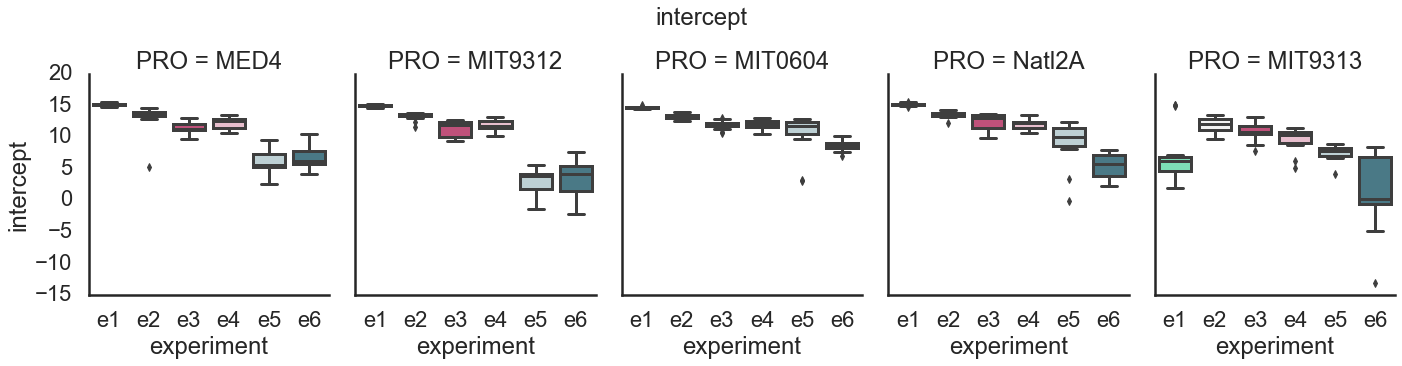

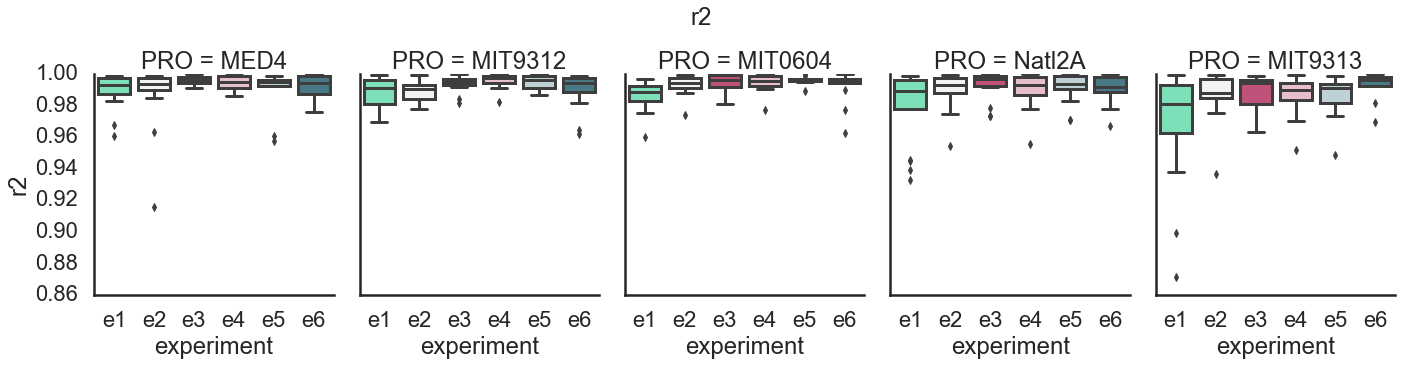

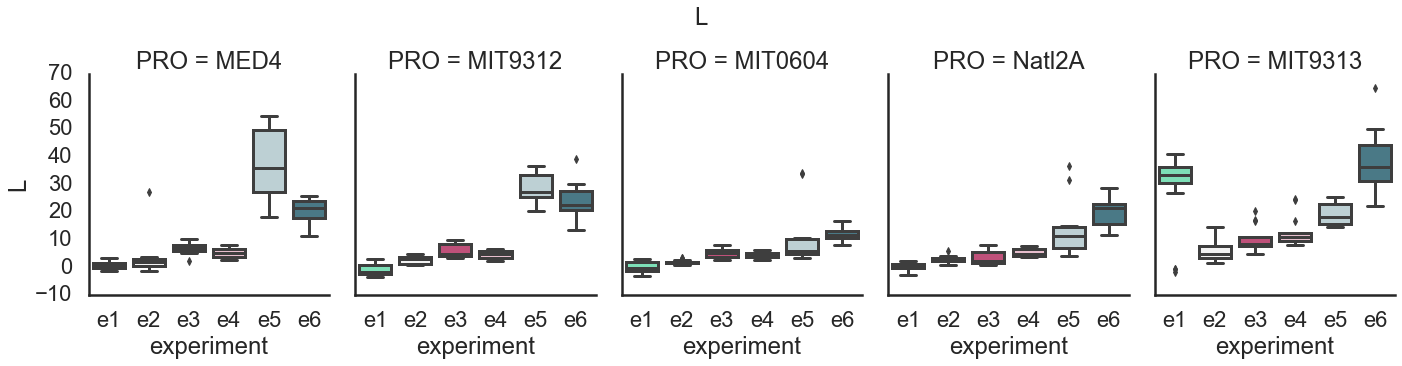

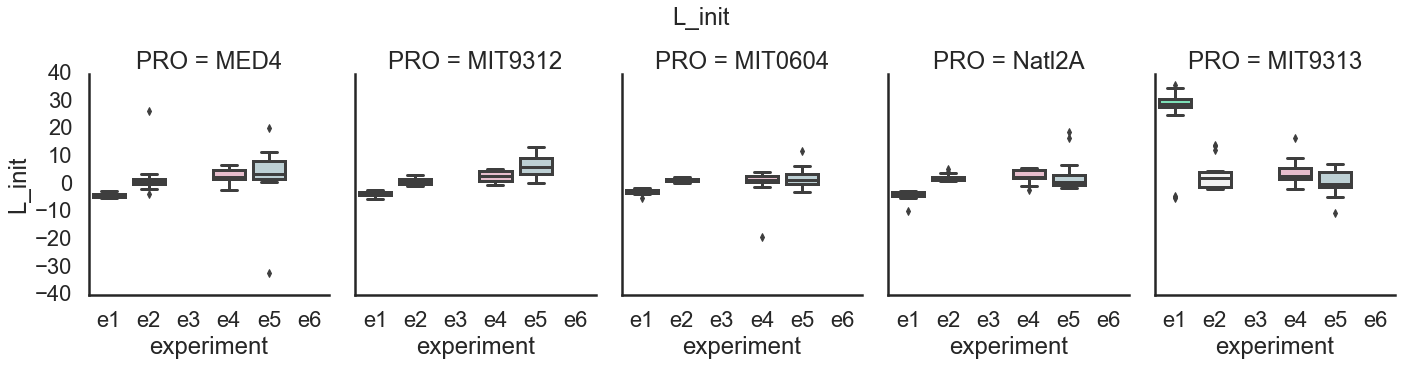

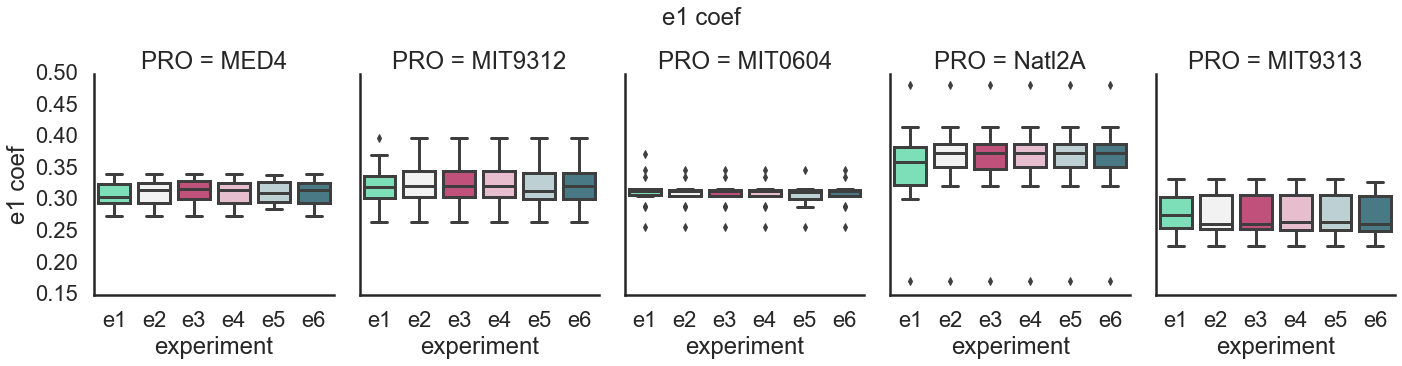

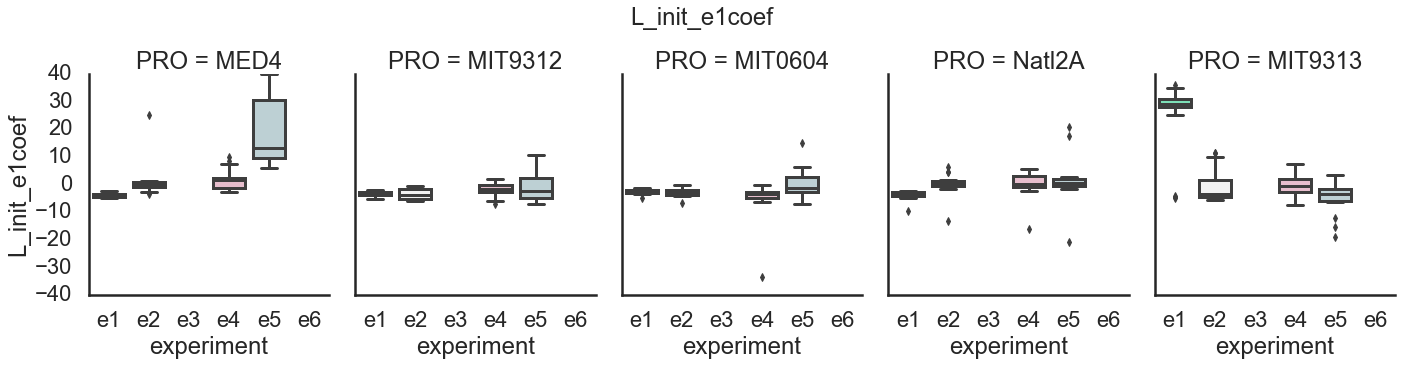

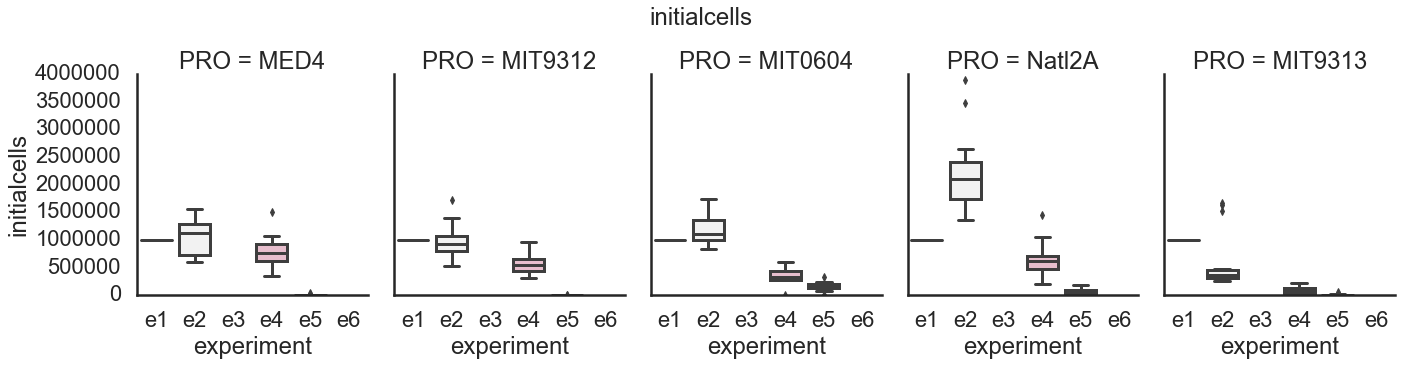

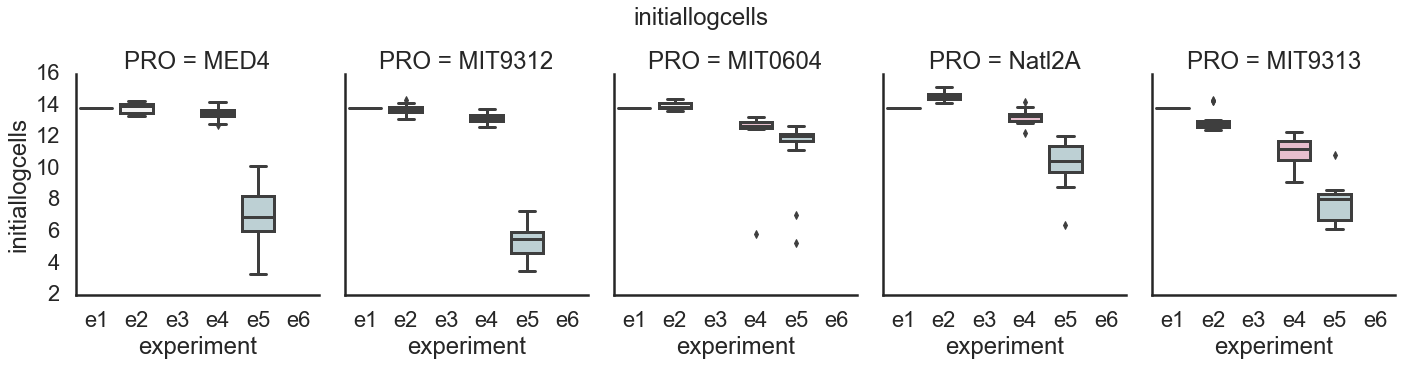

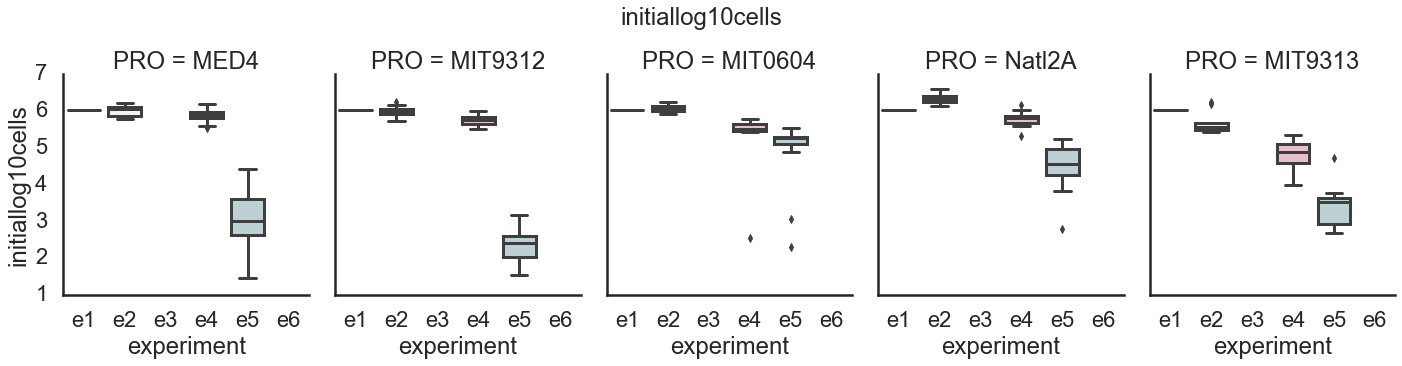

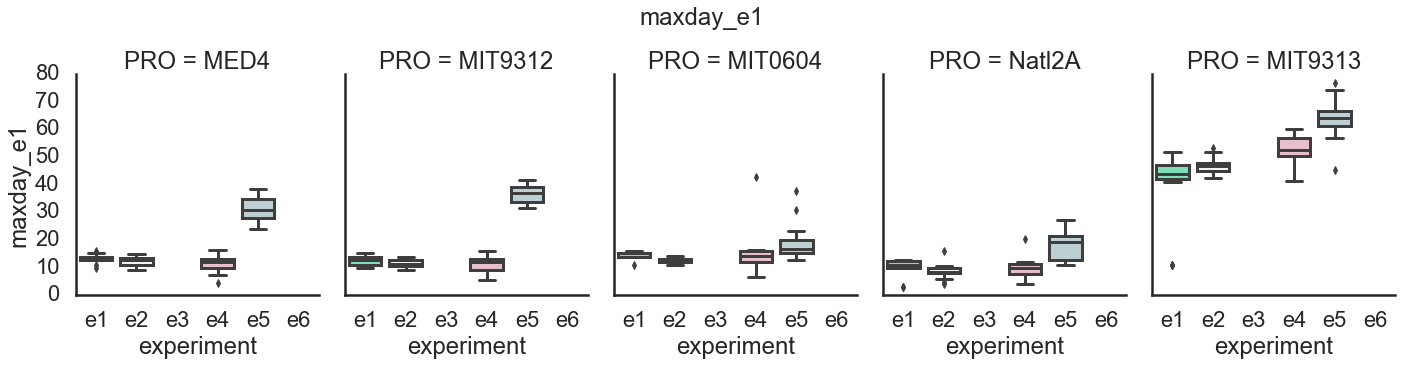

In [46]:
for i in ['maxday', 'maxlogcells', 'logcells0', 'log10cells0', 'intercept', 'coef', 'r2', 'L', 
          'L_init', 'e1 coef','L_init_e1coef', 'initialcells', 'initiallogcells',
       'initiallog10cells', 'maxday_e1']:
    sns.catplot(data=lagsdf, x='experiment', y=i, kind='box', aspect=0.8, height=5,
                order=eallorder,palette=eallpallete,
                
                col='PRO', col_order=porder)
    plt.suptitle(i, y=1.05)

In [47]:
from statsmodels.formula.api import ols
for p in porder:
    mod = ols('coef ~ C(experiment)',
                    data=lagsdf.loc[lagsdf.PRO == p]
             ).fit()
    print(f'-------------------------- {p} ----------------------------')
    print(mod.summary())
    print(sm.stats.anova_lm(mod))
    pair_t = mod.t_test_pairwise("C(experiment)", method='b')
    print(pair_t.result_frame)
    print(f'-------------------------- {p} ----------------------------')
    print(pair_t.result_frame.loc[pair_t.result_frame['reject-b'], 'pvalue-b'])
    #aov_table = sm.stats.anova_lm(mod, typ=2)
    #print(aov_table)

-------------------------- MED4 ----------------------------
                            OLS Regression Results                            
Dep. Variable:                   coef   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     10.56
Date:                Wed, 13 May 2020   Prob (F-statistic):           8.70e-08
Time:                        11:01:05   Log-Likelihood:                 127.81
No. Observations:                  85   AIC:                            -243.6
Df Residuals:                      79   BIC:                            -229.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

No handles with labels found to put in legend.


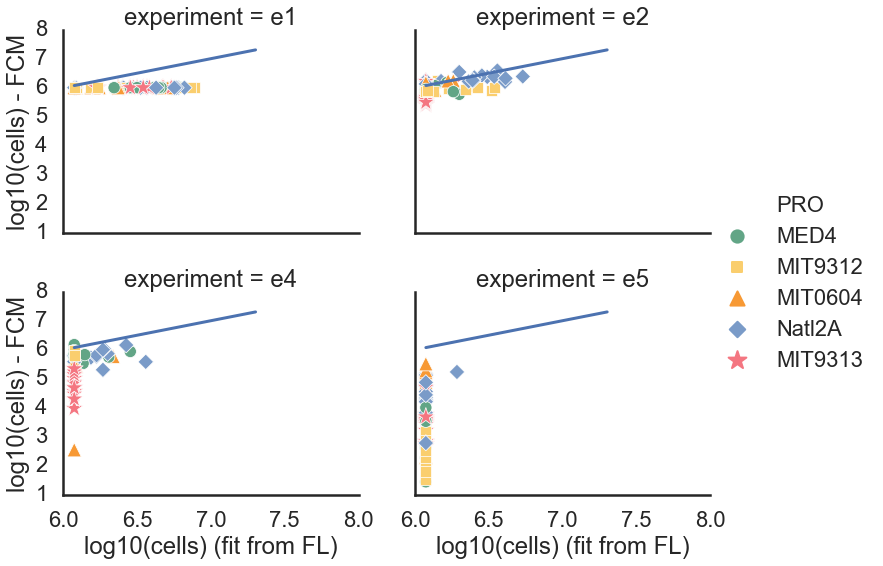

In [48]:
#for e in ['e1', 'e2', 'e4', 'e5']: 
g = sns.relplot(data=lagsdf.loc[lagsdf.culture.isin(['Co_Culture', 'Axenic'])], 
                                x='log10cells0', y='initiallog10cells', hue='PRO', 
                height=4, aspect=1,
            col='experiment', col_wrap=2, col_order=['e1', 'e2', 'e4', 'e5'], 
                palette=ppallete, hue_order=porder,
                style='PRO', style_order=porder, markers=pmarkers,
                size='PRO', size_order=porder, sizes=psizes,
                facet_kws=dict(ylim=(1,8), xlim=(6,8), legend_out=True)
            )
g.map(sns.lineplot, x=lagsdf['log10cells0'], y=lagsdf['log10cells0'], linestyle='dashed' )
g.set_axis_labels('log10(cells) (fit from FL)', 'log10(cells) - FCM')
plt.legend(bbox_to_anchor=(1.6,1), frameon=False)

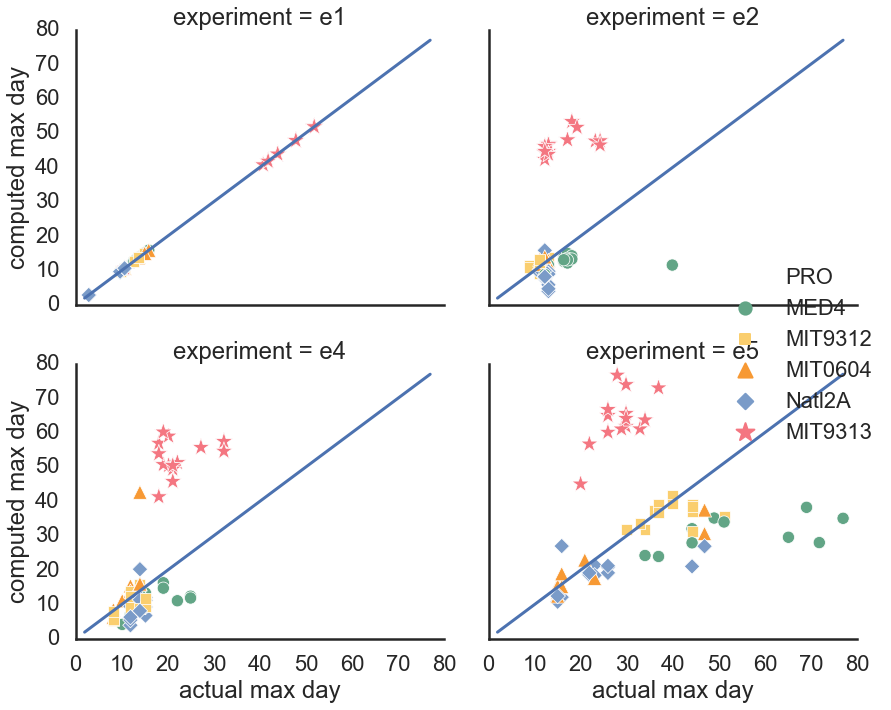

In [49]:
#for e in ['e1', 'e2', 'e4', 'e5']: 
g = sns.relplot(data=lagsdf.loc[lagsdf.culture.isin(['Co_Culture', 'Axenic'])], 
                                x='maxday', y='maxday_e1', hue='PRO', 
            col='experiment', col_wrap=2, col_order=['e1', 'e2', 'e4', 'e5'], 
                palette=ppallete, hue_order=porder,
                style='PRO', style_order=porder, markers=pmarkers,
                size='PRO', size_order=porder, sizes=psizes,
                facet_kws=dict(ylim=(0,80), xlim=(0,80))
            )
g.map(sns.lineplot, x=lagsdf['maxday'], y=lagsdf['maxday'], linestyle='dashed' )
g.set_axis_labels('actual max day', 'computed max day')


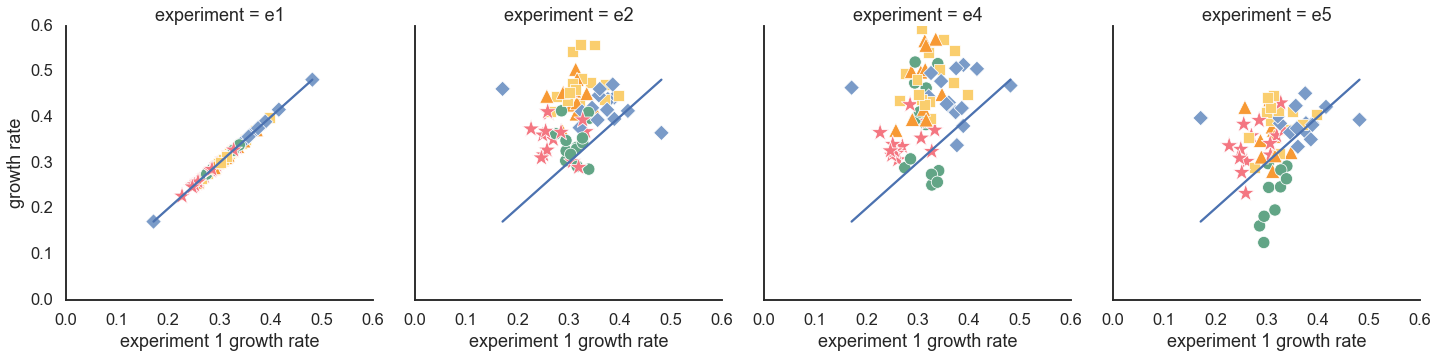

In [80]:
#for e in ['e1', 'e2', 'e4', 'e5']: 
sns.set_context('talk')
sns.set_style('white')
g = sns.relplot(data=lagsdf.loc[lagsdf.culture.isin(['Co_Culture', 'Axenic'])], 
                                x='e1 coef', y='coef', hue='PRO', 
            col='experiment', #col_wrap=2,
                col_order=['e1', 'e2', 'e4', 'e5'], 
                palette=ppallete, hue_order=porder,
                style='PRO', style_order=porder, markers=pmarkers,
                size='PRO', size_order=porder, sizes=psizes,
                facet_kws=dict(ylim=(0,0.6), xlim=(0,0.6)),
                legend=False
                
            )
g.map(sns.lineplot, x=lagsdf['e1 coef'], y=lagsdf['e1 coef'], linestyle='dashed' )
g.set_axis_labels('experiment 1 growth rate', 'growth rate')
#plt.legend(False)

In [51]:
lagsdf.columns

Index(['experiment', 'sample', 'PRO', 'ALT', 'culture', 'experiment_sample',
       'maxday', 'minday', 'maxlogcells', 'maxcells', 'logcells0',
       'log10cells0', 'intercept', 'coef', 'r2', 'L', 'initialcells',
       'initiallogcells', 'initiallog10cells', 'L_init', 'e1 coef',
       'e1 L_init', 'L_init_e1coef', 'maxday_e1'],
      dtype='object')

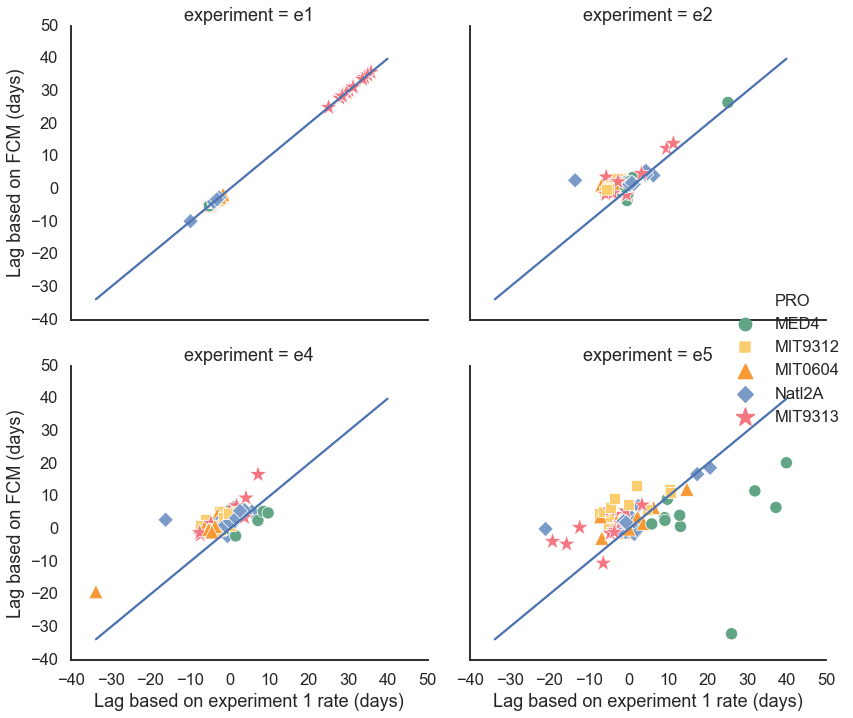

In [52]:
#for e in ['e1', 'e2', 'e4', 'e5']: 
g = sns.relplot(data=lagsdf.loc[lagsdf.culture.isin(['Co_Culture', 'Axenic'])], 
                                x='L_init_e1coef', y='L_init', hue='PRO', 
            col='experiment', col_wrap=2, col_order=['e1', 'e2', 'e4', 'e5'], 
                palette=ppallete, hue_order=porder,
                style='PRO', style_order=porder, markers=pmarkers,
                size='PRO', size_order=porder, sizes=psizes,
                #facet_kws=dict(ylim=(0,0.6), xlim=(0,0.6))
            )
g.map(sns.lineplot, x=lagsdf['L_init_e1coef'], y=lagsdf['L_init_e1coef'], linestyle='dashed' )
g.set_axis_labels('Lag based on experiment 1 rate (days)', 'Lag based on FCM (days)')


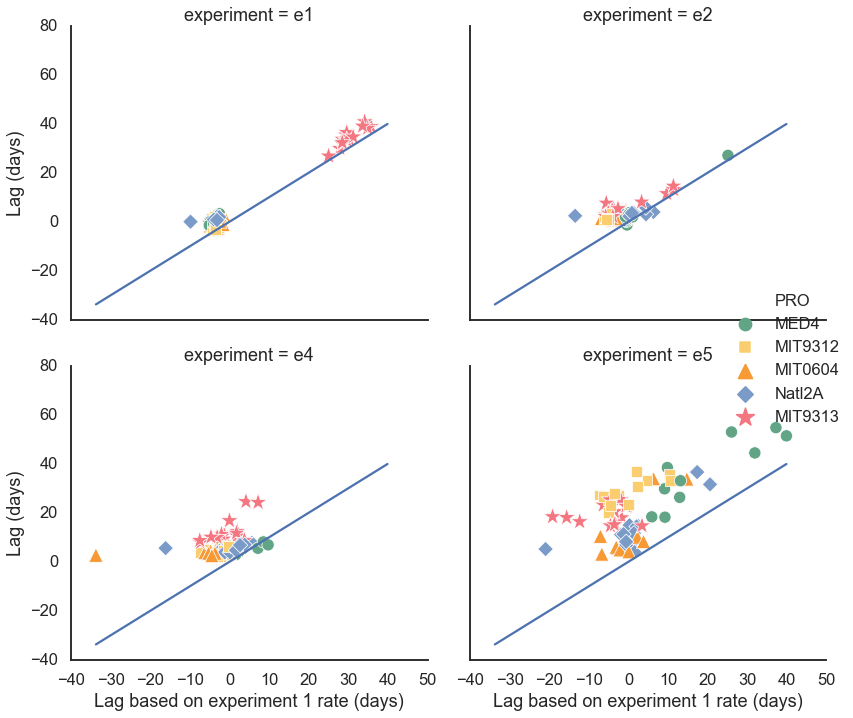

In [53]:
#for e in ['e1', 'e2', 'e4', 'e5']: 
g = sns.relplot(data=lagsdf.loc[lagsdf.culture.isin(['Co_Culture', 'Axenic'])], 
                                x='L_init_e1coef', y='L', hue='PRO', 
            col='experiment', col_wrap=2, col_order=['e1', 'e2', 'e4', 'e5'], 
                palette=ppallete, hue_order=porder,
                style='PRO', style_order=porder, markers=pmarkers,
                size='PRO', size_order=porder, sizes=psizes,
                #facet_kws=dict(ylim=(0,0.6), xlim=(0,0.6))
            )
g.map(sns.lineplot, x=lagsdf['L_init_e1coef'], y=lagsdf['L_init_e1coef'], linestyle='dashed' )
g.set_axis_labels('Lag based on experiment 1 rate (days)', 'Lag (days)')


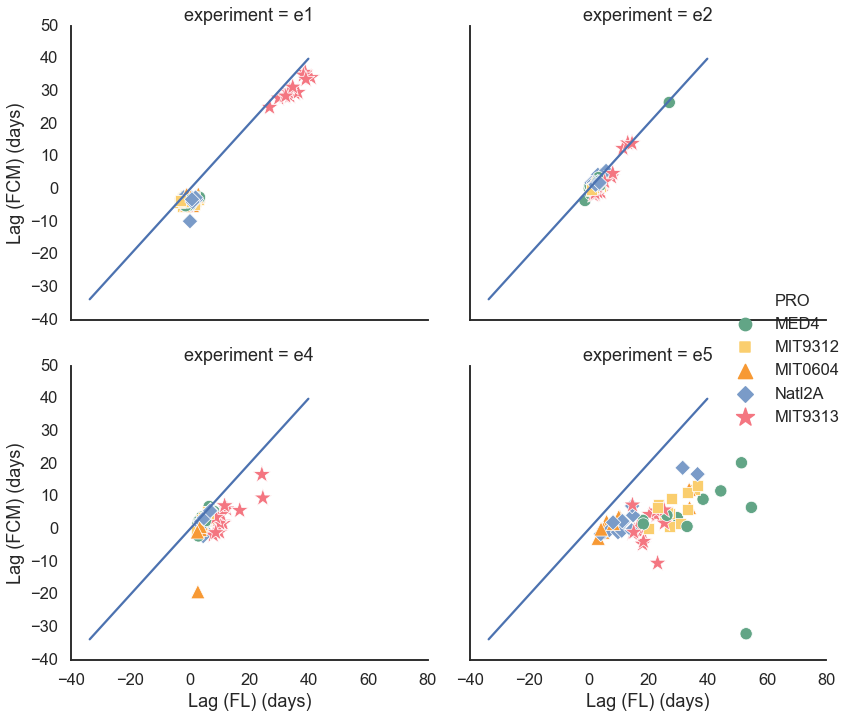

In [54]:
#for e in ['e1', 'e2', 'e4', 'e5']: 
g = sns.relplot(data=lagsdf.loc[lagsdf.culture.isin(['Co_Culture', 'Axenic'])], 
                                x='L', y='L_init', hue='PRO', 
            col='experiment', col_wrap=2, col_order=['e1', 'e2', 'e4', 'e5'], 
                palette=ppallete, hue_order=porder,
                style='PRO', style_order=porder, markers=pmarkers,
                size='PRO', size_order=porder, sizes=psizes,
                #facet_kws=dict(ylim=(0,0.6), xlim=(0,0.6))
            )
g.map(sns.lineplot, x=lagsdf['L_init_e1coef'], y=lagsdf['L_init_e1coef'], linestyle='dashed' )
g.set_axis_labels('Lag (FL) (days)', 'Lag (FCM) (days)')


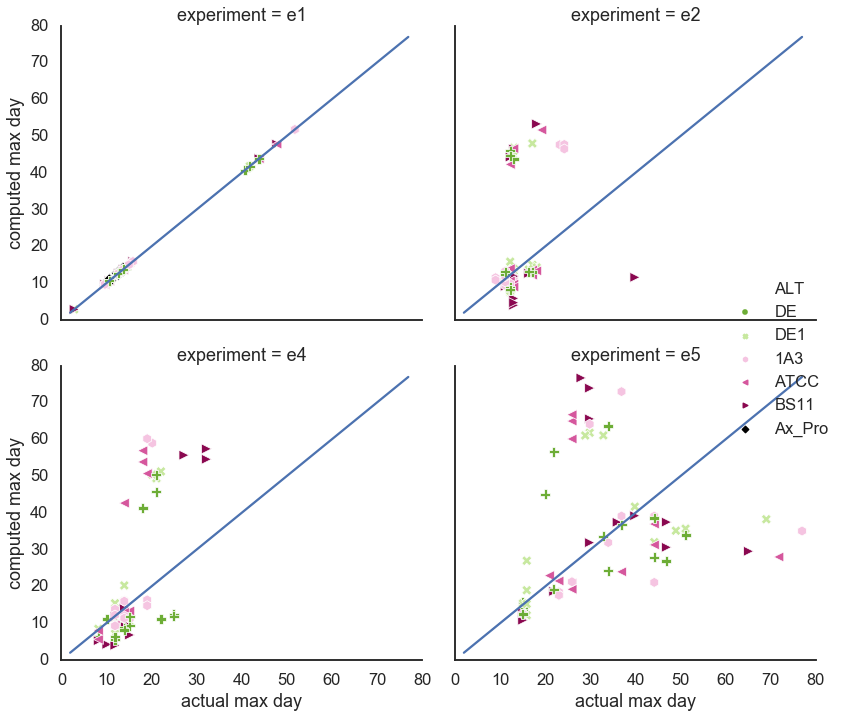

In [55]:
#for e in ['e1', 'e2', 'e4', 'e5']: 
g = sns.relplot(data=lagsdf.loc[lagsdf.culture.isin(['Co_Culture', 'Axenic'])], 
                                x='maxday', y='maxday_e1', hue='ALT', 
            col='experiment', col_wrap=2, col_order=['e1', 'e2', 'e4', 'e5'], 
                palette=apallete + ['black'], hue_order=aorder + ['Ax_Pro'],
                s=100,
                style='ALT', style_order=aorder+ ['Ax_Pro'], markers=amarkers + ['D'],
                facet_kws=dict(ylim=(0,80), xlim=(0,80))
            )
g.map(sns.lineplot, x=lagsdf['maxday'], y=lagsdf['maxday'], linestyle='dashed' )
g.set_axis_labels('actual max day', 'computed max day')


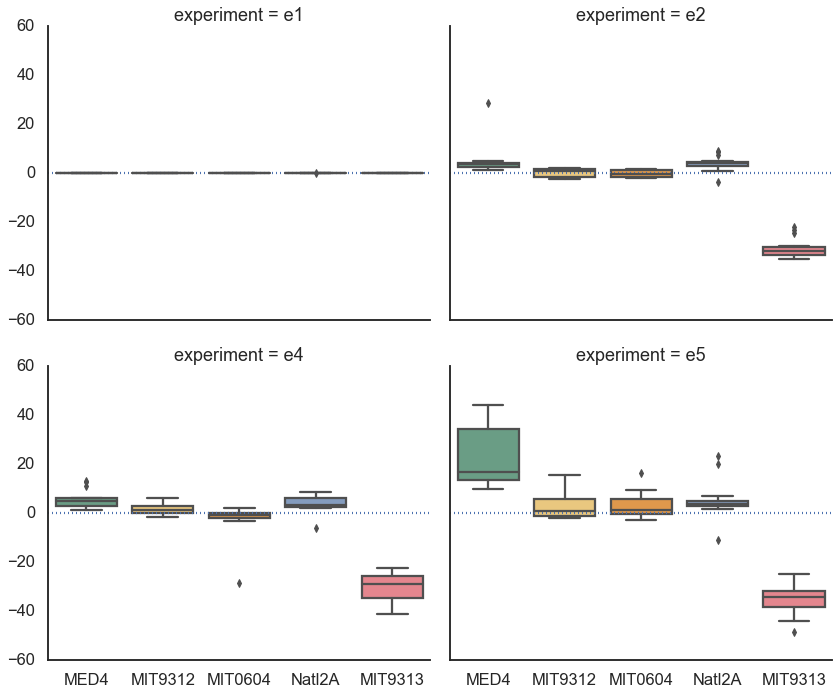

In [56]:
lagsdf['max day diff (actual - computed)'] = lagsdf['maxday'] - lagsdf['maxday_e1']
g = sns.catplot(data=lagsdf.loc[lagsdf.culture.isin(['Co_Culture', 'Axenic'])], 
                                x='PRO', y='max day diff (actual - computed)', #hue='PRO', 
            col='experiment', col_wrap=2, col_order=['e1', 'e2', 'e4', 'e5'], 
                palette=ppallete, order=porder,
                aspect=1.2,
                #style='PRO', style_order=porder, markers=pmarkers,
                #size='PRO', size_order=porder, sizes=psizes,
                #facet_kws=dict(ylim=(0,80))
                kind='box',
            )
def plot_axhline0(**kwargs):
    plt.axhline(0,**kwargs)
g.map(plot_axhline0, ls=':')


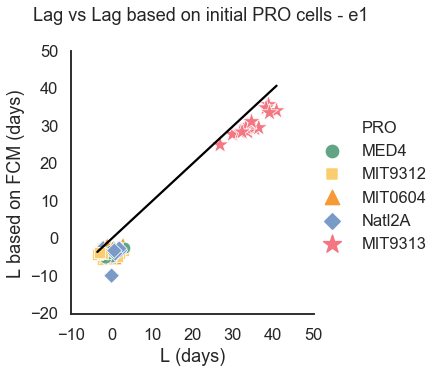

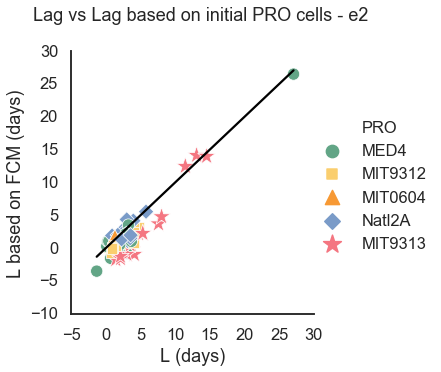

In [57]:
sns.set_context('talk')
sns.set_style('white')
for e in ['e1','e2','e4','e5']:
    g = sns.relplot(data=lagsdf.loc[lagsdf.experiment.isin([e]) & lagsdf.PRO.isin(porder)], 
            x='L', y='L_init',  hue='PRO', s=50, #legend=False,
                    hue_order=porder, palette=ppallete,
                    style='PRO', style_order=porder, markers=pmarkers,
                    size='PRO', size_order=porder, sizes=psizes,
                   )
    sns.lineplot(x=lagsdf.loc[lagsdf.experiment.isin([e]),'L'], 
                 y=lagsdf.loc[lagsdf.experiment.isin([e]),'L'], color='black', ax=g.ax, legend=False )
    g.set_axis_labels('L (days)', 'L based on FCM (days)')
    plt.suptitle(f'Lag vs Lag based on initial PRO cells - {e}', y=1.05)

In [58]:
lagsdf.columns

Index(['experiment', 'sample', 'PRO', 'ALT', 'culture', 'experiment_sample',
       'maxday', 'minday', 'maxlogcells', 'maxcells', 'logcells0',
       'log10cells0', 'intercept', 'coef', 'r2', 'L', 'initialcells',
       'initiallogcells', 'initiallog10cells', 'L_init', 'e1 coef',
       'e1 L_init', 'L_init_e1coef', 'maxday_e1',
       'max day diff (actual - computed)'],
      dtype='object')

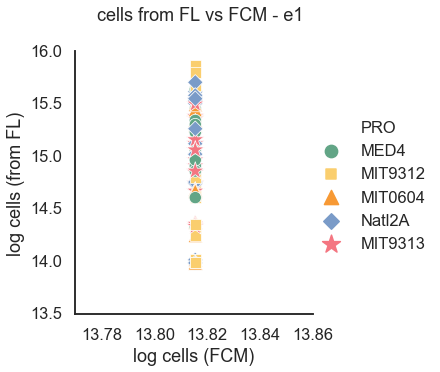

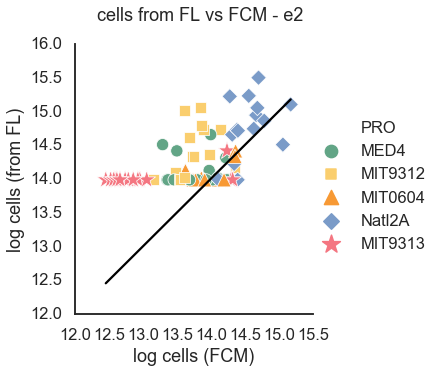

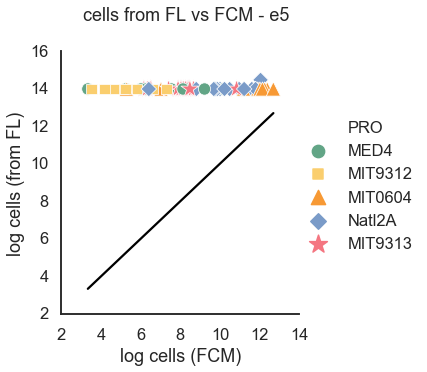

In [59]:
sns.set_context('talk')
sns.set_style('white')
for e in ['e1','e2','e4','e5']:
    g = sns.relplot(data=lagsdf.loc[lagsdf.experiment.isin([e]) & lagsdf.PRO.isin(porder)], 
            y='logcells0', x='initiallogcells',  hue='PRO', s=50, #legend=False,
                    hue_order=porder, palette=ppallete,
                    style='PRO', style_order=porder, markers=pmarkers,
                    size='PRO', size_order=porder, sizes=psizes,
                   )
    sns.lineplot(x=lagsdf.loc[lagsdf.experiment.isin([e]),'initiallogcells'], 
                 y=lagsdf.loc[lagsdf.experiment.isin([e]),'initiallogcells'], color='black', ax=g.ax, legend=False )
    g.set_axis_labels('log cells (FCM)', 'log cells (from FL)', )
    plt.suptitle(f'cells from FL vs FCM - {e}', y=1.05)
    plt.ticklabel_format(useOffset=False)

In [60]:
worse_l = lagsdf.nsmallest(10, 'L')['experiment_sample']

In [61]:
lagsdf.nsmallest(10, 'r2')

experiment sample      PRO     ALT      culture experiment_sample  \
41          e1    22C  MIT9313    ATCC   Co_Culture           e1, 22C   
6           e1    12A  MIT9313     DE1   Co_Culture           e1, 12A   
68          e1    37B      all     all  All_strains           e1, 37B   
94          e2    11A     MED4     DE1   Co_Culture           e2, 11A   
67          e1    37A      all     all  All_strains           e1, 37A   
69          e1    37C      all     all  All_strains           e1, 37C   
47          e1    24C   Natl2A    ATCC   Co_Culture           e1, 24C   
140         e2     2A  MIT9313     1A3   Co_Culture            e2, 2A   
58          e1    29C  MIT9313  Ax_Pro       Axenic           e1, 29C   
52          e1    27C   Natl2A  Ax_Pro       Axenic           e1, 27C   

        maxday     minday  maxlogcells      maxcells  ...          L  \
41   43.836806  33.886111    17.742529  5.075540e+07  ...  31.800872   
6    43.836806  33.886111    17.996596  6.543686e+07  ...  29.902374   
68   20.660417   0.000000    19.498022  2.936860e+08  ...   5.854421   
94   16.310000   4.110000    19.021496  1.823604e+08  ...  -1.304570   
67   22.951389   0.000000    19.674600  3.504050e+08  ...   5.860997   
69   16.952083   0.000000    19.441551  2.775610e+08  ...   4.001926   
47   10.603472   0.000000    18.610670  1.209236e+08  ...  -0.551893   
140  23.160000  12.990000    17.691294  4.822048e+07  ...  11.474504   
58   10.603472   0.000000    18.238225  8.332218e+07  ...  -0.609449   
52   12.650694   0.000000    19.022075  1.824660e+08  ...   1.256358   

     initialcells  initiallogcells  initiallog10cells     L_init   e1 coef  \
41   1.000000e+06        13.815511           6.000000  28.463938  0.255451   
6    1.000000e+06        13.815511           6.000000  27.847106  0.261486   
68   1.000000e+06        13.815511           6.000000  -9.183386  0.190408   
94   6.310714e+05        13.355174           5.800079  -3.503270  0.339805   
67   1.000000e+06        13.815511           6.000000 -10.697327  0.174125   
69   1.000000e+06        13.815511           6.000000 -10.776119  0.202900   
47   1.000000e+06        13.815511           6.000000  -4.289072  0.321984   
140  1.618456e+06        14.296983           6.209101  12.461117  0.251595   
58   1.000000e+06        13.815511           6.000000  -5.001191  0.283423   
52   1.000000e+06        13.815511           6.000000  -4.578011  0.302203   

     e1 L_init  L_init_e1coef  maxday_e1  max day diff (actual - computed)  
41   28.463938      28.463938  43.836806                          0.000000  
6    27.847106      27.847106  43.836806                          0.000000  
68   -9.183386      -9.183386  20.660417                          0.000000  
94   -3.026942      -0.365233  13.648290                          2.661710  
67  -10.697327     -10.697327  22.951389                          0.000000  
69  -10.776119     -10.776119  16.952083                          0.000000  
47   -4.289072      -4.289072  10.603472                          0.000000  
140  34.118892       9.668818  47.610075                        -24.450075  
58   -5.001191      -5.001191  10.603472                          0.000000  
52   -4.578011      -4.578011  12.650694                          0.000000  

[10 rows x 25 columns]

In [62]:
def plot_growth(es):
    sns.set(rc={'figure.figsize':(10,5)})
    maxday = lagsdf.loc[lagsdf.experiment_sample == es, 'maxday'].unique()[0]
    minday = lagsdf.loc[lagsdf.experiment_sample == es, 'minday'].unique()[0]
    r2 = lagsdf.loc[lagsdf.experiment_sample == es, 'r2'].unique()[0]
    L = lagsdf.loc[lagsdf.experiment_sample == es, 'L'].unique()[0]
    
    d = df.loc[df.experiment_sample == es].reset_index()
    d['fitted_growth'] = d.day*lagsdf.loc[lagsdf.experiment_sample == es, 'coef'].unique() + lagsdf.loc[lagsdf.experiment_sample == es, 'intercept'].unique()
    d.loc[d.day > maxday, 'fitted_growth'] = np.NaN
    d.loc[d.day < minday, 'fitted_growth'] = np.NaN
    sns.lineplot(data=d,
                 x='day', y='logcells',  style=True, markers=True,label='logcells')
    sns.lineplot(data=d,
        x='day', y='fitted_growth',  style=True, markers=True,label='fit')
    plt.title(f'{es}: L={L:.2f}, r2={r2:.2f}')
    plt.show()


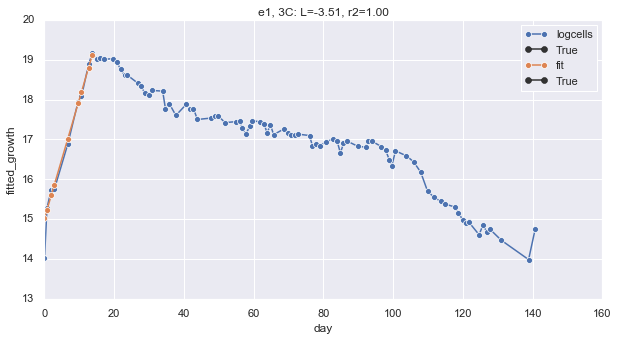

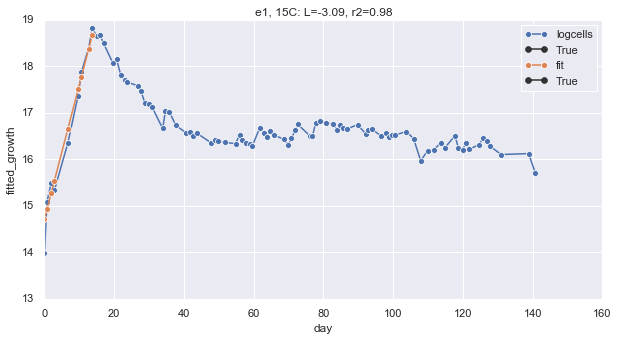

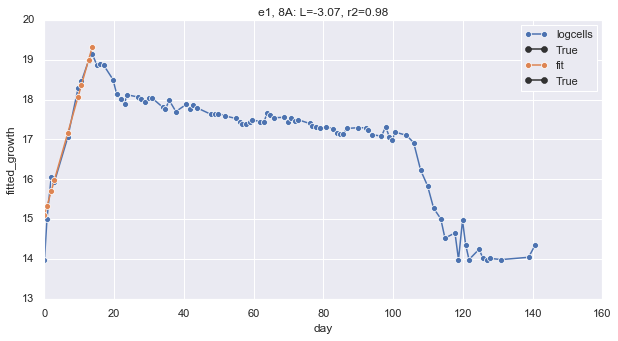

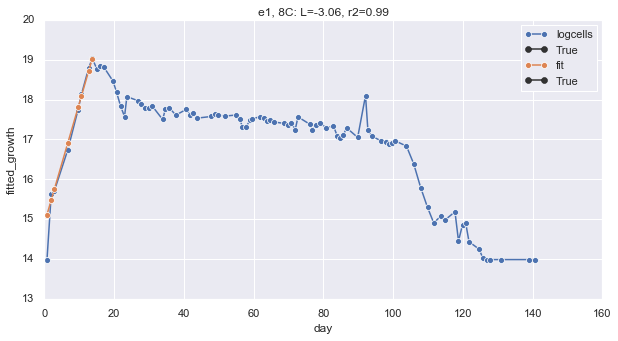

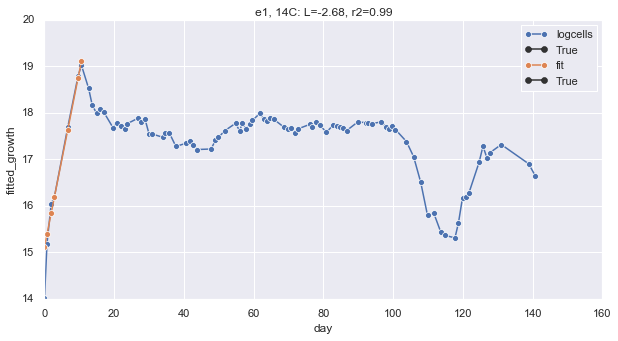

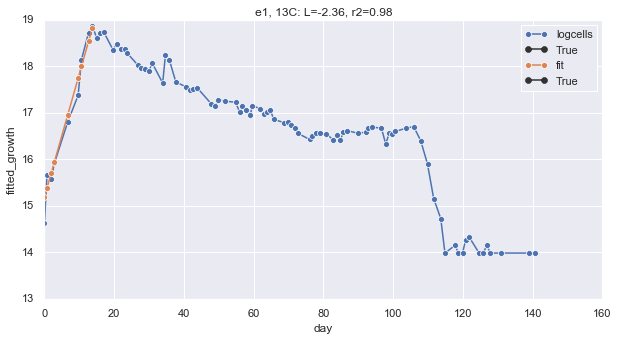

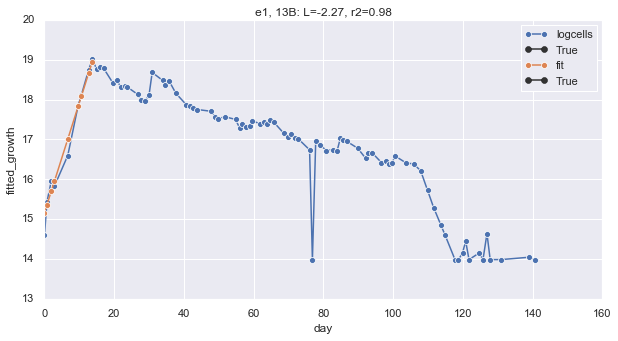

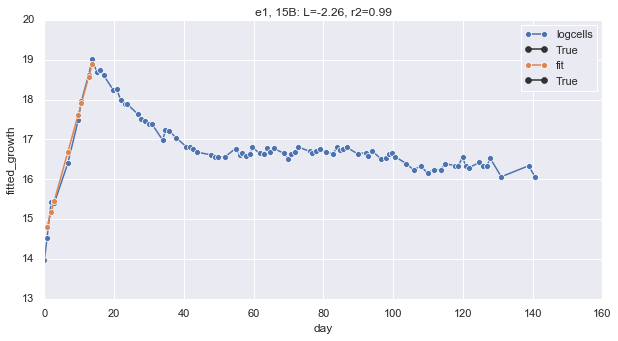

In [63]:
for es in worse_l:
    plot_growth(es)

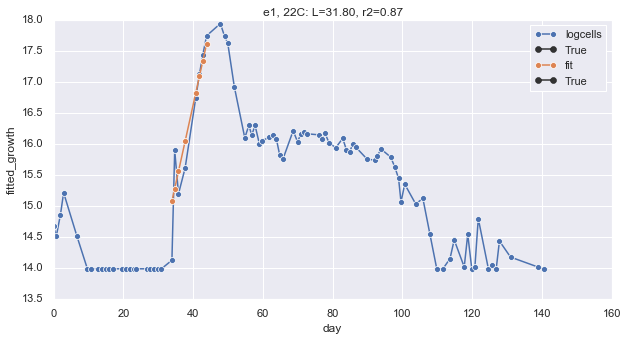

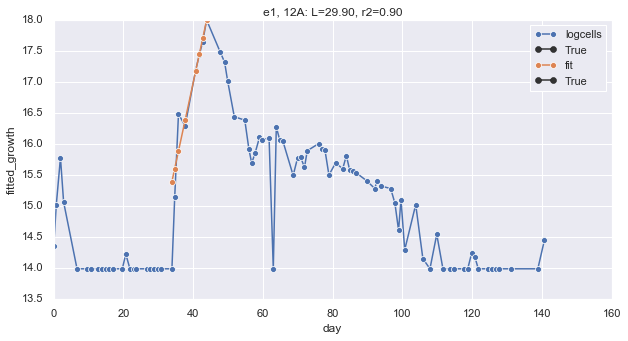

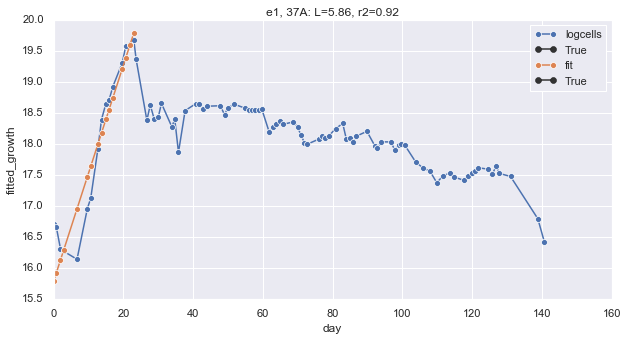

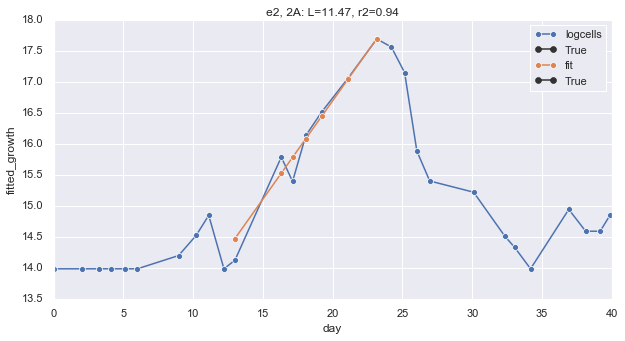

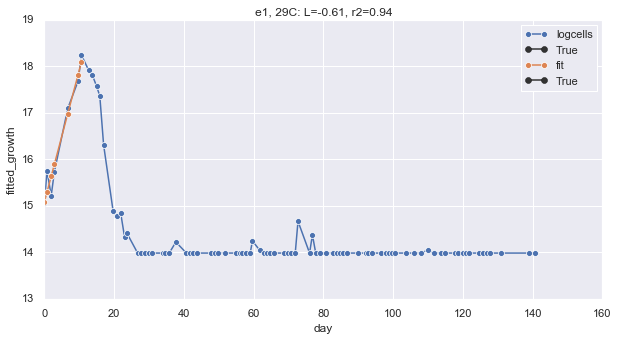

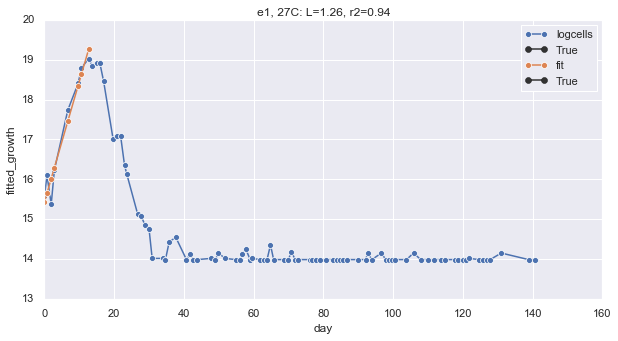

In [64]:
worse_r2 = lagsdf.nsmallest(10, 'r2')['experiment_sample']
for es in worse_r2:
    plot_growth(es)

In [65]:
sns.relplot(data=lagsdf, x='maxday', y='L', hue='experiment', size='r2')

In [66]:
lagsdf.loc[lagsdf.maxday>60]

experiment sample      PRO   ALT     culture experiment_sample  maxday  \
325         e5    11C     MED4   DE1  Co_Culture           e5, 11C   69.01   
337         e5    16B     MED4  BS11  Co_Culture           e5, 16B   65.08   
347         e5     1C     MED4   1A3  Co_Culture            e5, 1C   76.94   
350         e5    21B     MED4  ATCC  Co_Culture           e5, 21B   71.78   
410         e6    17A  MIT9313  BS11  Co_Culture           e6, 17A   69.70   

     minday  maxlogcells      maxcells  ...          L  initialcells  \
325   61.86    15.996908  8.858681e+06  ...  52.950675     28.000000   
337   48.95    18.045422  6.871114e+07  ...  44.418749   1900.538748   
347   61.86    17.578574  4.308020e+07  ...  54.725087    495.000000   
350   54.95    17.714390  4.934711e+07  ...  51.382031   4023.207626   
410   62.70    15.972773  8.647437e+06  ...  64.943500           NaN   

     initiallogcells  initiallog10cells     L_init   e1 coef  e1 L_init  \
325         3.332205           1.447158 -32.029757  0.294652  -4.753137   
337         7.549893           3.278877  11.687548  0.316455  -3.640998   
347         6.204558           2.694605   6.647716  0.286468  -4.664295   
350         8.299835           3.604572  20.301099  0.295219  -3.913593   
410              NaN                NaN        NaN  0.259382  29.363800   

     L_init_e1coef  maxday_e1  max day diff (actual - computed)  
325      26.028038  38.228825                         30.781175  
337      31.914038  29.524965                         35.555035  
347      37.235642  35.040063                         41.899937  
350      39.889960  27.976447                         43.803553  
410            NaN        NaN                               NaN  

[5 rows x 25 columns]

In [67]:
def plot_growth(es):
    maxday = lagsdf.loc[lagsdf.experiment_sample == es, 'maxday'].unique()[0]
    minday = lagsdf.loc[lagsdf.experiment_sample == es, 'minday'].unique()[0]
    r2 = lagsdf.loc[lagsdf.experiment_sample == es, 'r2'].unique()[0]
    L = lagsdf.loc[lagsdf.experiment_sample == es, 'L'].unique()[0]
    
    d = df.loc[df.experiment_sample == es].reset_index()
    d['fitted_growth'] = d.day*lagsdf.loc[lagsdf.experiment_sample == es, 'coef'].unique() + lagsdf.loc[lagsdf.experiment_sample == es, 'intercept'].unique()
    d.loc[d.day > maxday, 'fitted_growth'] = np.NaN
    d.loc[d.day < minday, 'fitted_growth'] = np.NaN
    sns.lineplot(data=d,
                 x='day', y='logcells',  style=True, markers=True,label='logcells')
    sns.lineplot(data=d,
        x='day', y='fitted_growth',  style=True, markers=True,label='fit')
    plt.title(f'{es}: L={L:.2f}, r2={r2:.2f}')
    plt.show()


In [68]:
def add_fit(d):
    es = d.name
    lagsdf_row = lagsdf.loc[lagsdf.experiment_sample == es].iloc[0]
    maxday = lagsdf_row['maxday']
    minday = lagsdf_row['minday']
    coef = lagsdf_row['coef']
    intercept = lagsdf_row['intercept']
    
    d['fitted_growth'] = d.day*coef + intercept
    d.loc[d.day > maxday, 'fitted_growth'] = np.NaN
    d.loc[d.day < minday, 'fitted_growth'] = np.NaN
    return d
    

df_fit = df.reset_index(drop=True).groupby(['experiment_sample']).apply(add_fit)


In [69]:
df_fit.columns

Index(['day', 'experiment', 'sample', 'FL', 'PRO', 'ALT', 'culture', 'FL_orig',
       'logFL', 'cumsumFL', 'cumsumlogFL', 'zscoreFL', 'diffFL', 'difflogFL',
       'diffday', 'rateFL', 'ratelogFL', 'experiment_sample', 'cells',
       'logcells', 'fitted_growth'],
      dtype='object')

In [70]:
df_fit_m = df_fit.melt(id_vars=['day', 'experiment', 'sample', 'PRO', 'ALT', 'culture', 'experiment_sample'],
            value_vars=['logcells', 'fitted_growth'], value_name='ln(cell/ml)', var_name='var' )

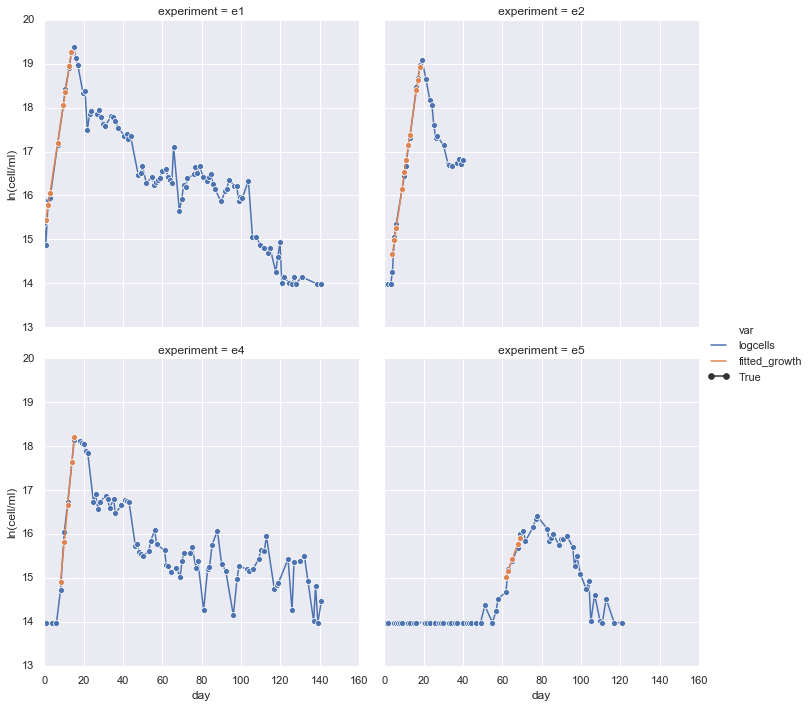

In [71]:

g = sns.relplot(data=df_fit_m.loc[df_fit_m['sample'].isin(['11C']) &
                               df_fit_m.experiment.isin(['e1','e2','e4','e5'])],
             x='day', y='ln(cell/ml)', hue='var',
                style=True, markers=True, col='experiment', col_wrap=2, kind='line')



In [72]:
with pd.option_context("display.precision", 2,):
    display(lagsdf.loc[lagsdf['sample'].isin(['11C'])&
           lagsdf.experiment.isin(['e1','e2','e4','e5']),]
                       
#           #['experiment', 
#         'log10cells0', 'initiallog10cells',
#        'coef', 'r2', 'L', 
#        'L_init', 'L_init_e1coef', 
#       'maxday', 'maxday_e1', ]]
           )

experiment sample   PRO  ALT     culture experiment_sample  maxday  \
5           e1    11C  MED4  DE1  Co_Culture           e1, 11C   13.69   
96          e2    11C  MED4  DE1  Co_Culture           e2, 11C   18.07   
248         e4    11C  MED4  DE1  Co_Culture           e4, 11C   15.14   
325         e5    11C  MED4  DE1  Co_Culture           e5, 11C   69.01   

     minday  maxlogcells  maxcells  ...      L  initialcells  initiallogcells  \
5      0.72        19.25  2.29e+08  ...   0.55    1000000.00            13.82   
96     4.11        18.97  1.72e+08  ...   1.70     639746.54            13.37   
248    8.14        18.15  7.62e+07  ...   6.36     886309.82            13.69   
325   61.86        16.00  8.86e+06  ...  52.95         28.00             3.33   

     initiallog10cells  L_init  e1 coef  e1 L_init  L_init_e1coef  maxday_e1  \
5                 6.00   -4.75     0.29      -4.75          -4.75      13.69   
96                5.81   -0.32     0.29      -4.75          -0.92      14.24   
248               5.95    5.76     0.29      -4.75           0.02      10.36   
325               1.45  -32.03     0.29      -4.75          26.03      38.23   

     max day diff (actual - computed)  
5                                0.00  
96                               3.83  
248                              4.78  
325                             30.78  

[4 rows x 25 columns]

In [73]:
### es = 'e5, 11C'
69 , (16.04 - 3.33) / 0.11, 69  - (16.04 - 14) / 0.11, 
#L = maxday - ((maxlogcells - logcells0) / coef)


(69, 115.54545454545453, 50.45454545454547)

In [74]:
lagsdf.nsmallest(10, 'initiallogcells')

experiment sample      PRO   ALT     culture experiment_sample  maxday  \
325         e5    11C     MED4   DE1  Co_Culture           e5, 11C   69.01   
356         e5    23C  MIT9312  ATCC  Co_Culture           e5, 23C   44.16   
383         e5     8A  MIT9312    DE  Co_Culture            e5, 8A   44.16   
343         e5    18C  MIT9312  BS11  Co_Culture           e5, 18C   39.84   
369         e5     3B  MIT9312   1A3  Co_Culture            e5, 3B   44.16   
355         e5    23A  MIT9312  ATCC  Co_Culture           e5, 23A   44.16   
324         e5    11B     MED4   DE1  Co_Culture           e5, 11B   48.95   
370         e5     3C  MIT9312   1A3  Co_Culture            e5, 3C   36.89   
348         e5    20B  MIT0604  BS11  Co_Culture           e5, 20B   46.87   
342         e5    18B  MIT9312  BS11  Co_Culture           e5, 18B   35.94   

     minday  maxlogcells      maxcells  ...          L  initialcells  \
325   61.86    15.996908  8.858681e+06  ...  52.950675     28.000000   
356   33.95    18.167771  7.765380e+07  ...  33.273868     33.982594   
383   36.89    17.134202  2.762419e+07  ...  36.692175     64.000000   
343   28.84    18.747340  1.386329e+08  ...  27.052330     69.622876   
369   33.95    18.277176  8.663167e+07  ...  30.784920    105.000000   
355   33.95    18.446846  1.026510e+08  ...  33.184251    159.138002   
324   39.84    17.112297  2.702566e+07  ...  38.452723    190.000000   
370   29.83    18.197696  8.001269e+07  ...  26.630947    191.000000   
348   36.89    18.115179  7.367537e+07  ...  33.909744    195.607128   
342   25.90    18.166410  7.754818e+07  ...  25.303754    257.770410   

     initiallogcells  initiallog10cells     L_init   e1 coef  e1 L_init  \
325         3.332205           1.447158 -32.029757  0.294652  -4.753137   
356         3.525848           1.531257   6.062113  0.370899  -2.552212   
383         4.158883           1.806180  13.401163  0.307613  -3.619839   
343         4.243093           1.842752   0.902104  0.342857  -3.111164   
369         4.653960           2.021189   1.718129  0.326044  -2.702401   
355         5.069772           2.201774  11.261150  0.398279  -2.327666   
324         5.247024           2.278754   9.135388  0.303269  -4.009267   
370         5.252273           2.281033   5.372088  0.299094  -4.174249   
348         5.276108           2.291385   6.591785  0.316636  -3.094895   
342         5.552069           2.411233   3.860807  0.307849  -3.564900   

     L_init_e1coef  maxday_e1  max day diff (actual - computed)  
325      26.028038  38.228825                         30.781175  
356       4.683187  36.924601                          7.235399  
383       1.979274  38.560887                          5.599113  
343      -2.464023  39.192859                          0.647141  
369       2.376628  39.080971                          5.079029  
355      10.572797  31.259537                         12.900463  
324       9.825424  35.115309                         13.834691  
370      -6.392172  39.107923                         -2.217923  
348       6.321645  37.453460                          9.416540  
342      -5.035763  37.410863                         -1.470863  

[10 rows x 25 columns]

In [75]:
lagsdf.nsmallest(10, 'L_init').T

325          291         65   \
experiment                                 e5           e4          e1   
sample                                    11C          25C         36A   
PRO                                      MED4      MIT0604        allP   
ALT                                       DE1         ATCC     all_Pro   
culture                            Co_Culture   Co_Culture     All_Pro   
experiment_sample                     e5, 11C      e4, 25C     e1, 36A   
maxday                                  69.01        13.94     6.67431   
minday                                  61.86         4.07   -0.325694   
maxlogcells                           15.9969      18.1614     18.5093   
maxcells                          8.85868e+06  7.71609e+07  1.0927e+08   
logcells0                              13.984       13.984     16.7468   
log10cells0                           6.07316      6.07316     7.27305   
intercept                              7.2674       13.056     16.7239   
coef                                 0.125344     0.371157    0.263318   
r2                                   0.957196     0.992192    0.995382   
L                                     52.9507      2.68485  -0.0192224   
initialcells                               28       355.45       1e+06   
initiallogcells                        3.3322      5.87339     13.8155   
initiallog10cells                     1.44716      2.55078           6   
L_init                               -32.0298     -19.1673    -11.1514   
e1 coef                              0.294652     0.257783    0.263318   
e1 L_init                            -4.75314     -5.04578    -11.1514   
L_init_e1coef                          26.028     -33.7281    -11.1514   
maxday_e1                             38.2288      42.6223     6.67431   
max day diff (actual - computed)      30.7812     -28.6823           0   

                                          66           69           67   \
experiment                                 e1           e1           e1   
sample                                    36B          37C          37A   
PRO                                      allP          all          all   
ALT                                   all_Pro          all          all   
culture                               All_Pro  All_strains  All_strains   
experiment_sample                     e1, 36B      e1, 37C      e1, 37A   
maxday                                1.92569      16.9521      22.9514   
minday                               -5.07431            0            0   
maxlogcells                           17.2831      19.4416      19.6746   
maxcells                          3.20603e+07  2.77561e+08  3.50405e+08   
logcells0                             16.7691       16.814      16.6987   
log10cells0                           7.28272      7.30221      7.25217   
intercept                             16.7662       15.796      15.7894   
coef                                 0.267559       0.2029     0.174125   
r2                                   0.999754     0.927367     0.917643   
L                                   0.0044712      4.00193        5.861   
initialcells                            1e+06        1e+06        1e+06   
initiallogcells                       13.8155      13.8155      13.8155   
initiallog10cells                           6            6            6   
L_init                               -11.0345     -10.7761     -10.6973   
e1 coef                              0.267559       0.2029     0.174125   
e1 L_init                            -11.0345     -10.7761     -10.6973   
L_init_e1coef                        -11.0345     -10.7761     -10.6973   
maxday_e1                             1.92569      16.9521      22.9514   
max day diff (actual - computed)  6.66134e-16            0            0   

                                          338          12           68   \
experiment                                 e5           e1           e1   
sample          

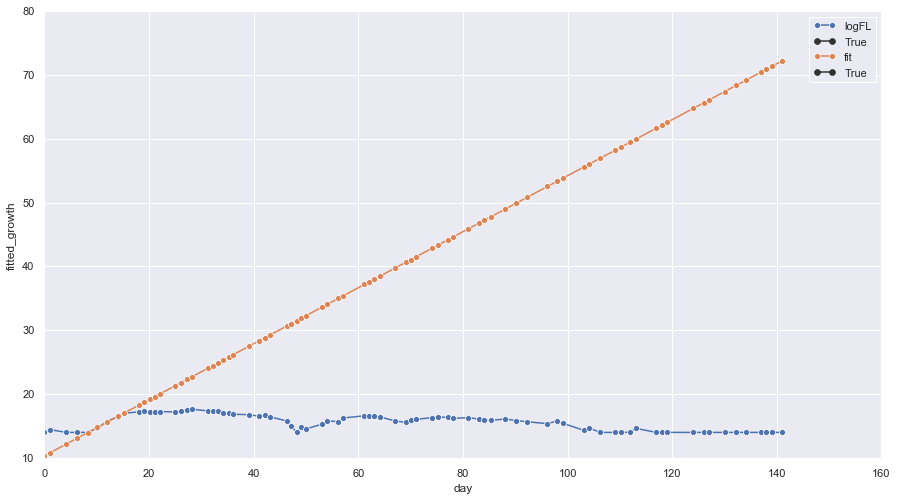

In [76]:
sns.set(rc={'figure.figsize':(15,8)})
es = 'e3, 8B'
d = df.loc[df.experiment_sample == es].reset_index()
d['fitted_growth'] = d.day*lagsdf.loc[lagsdf.experiment_sample == es, 'coef'].unique() + lagsdf.loc[lagsdf.experiment_sample == es, 'intercept'].unique()
sns.lineplot(data=d,
             x='day', y='logcells',  style=True, markers=True,label='logFL')
sns.lineplot(data=d,
    x='day', y='fitted_growth',  style=True, markers=True,label='fit')

#sns.lineplot(data=d, x='day', y='first_deriviative',  style=True, markers=True,label='1')
#sns.lineplot(data=d, x='day', y='second_deriviative',  style=True, markers=True,label='2')

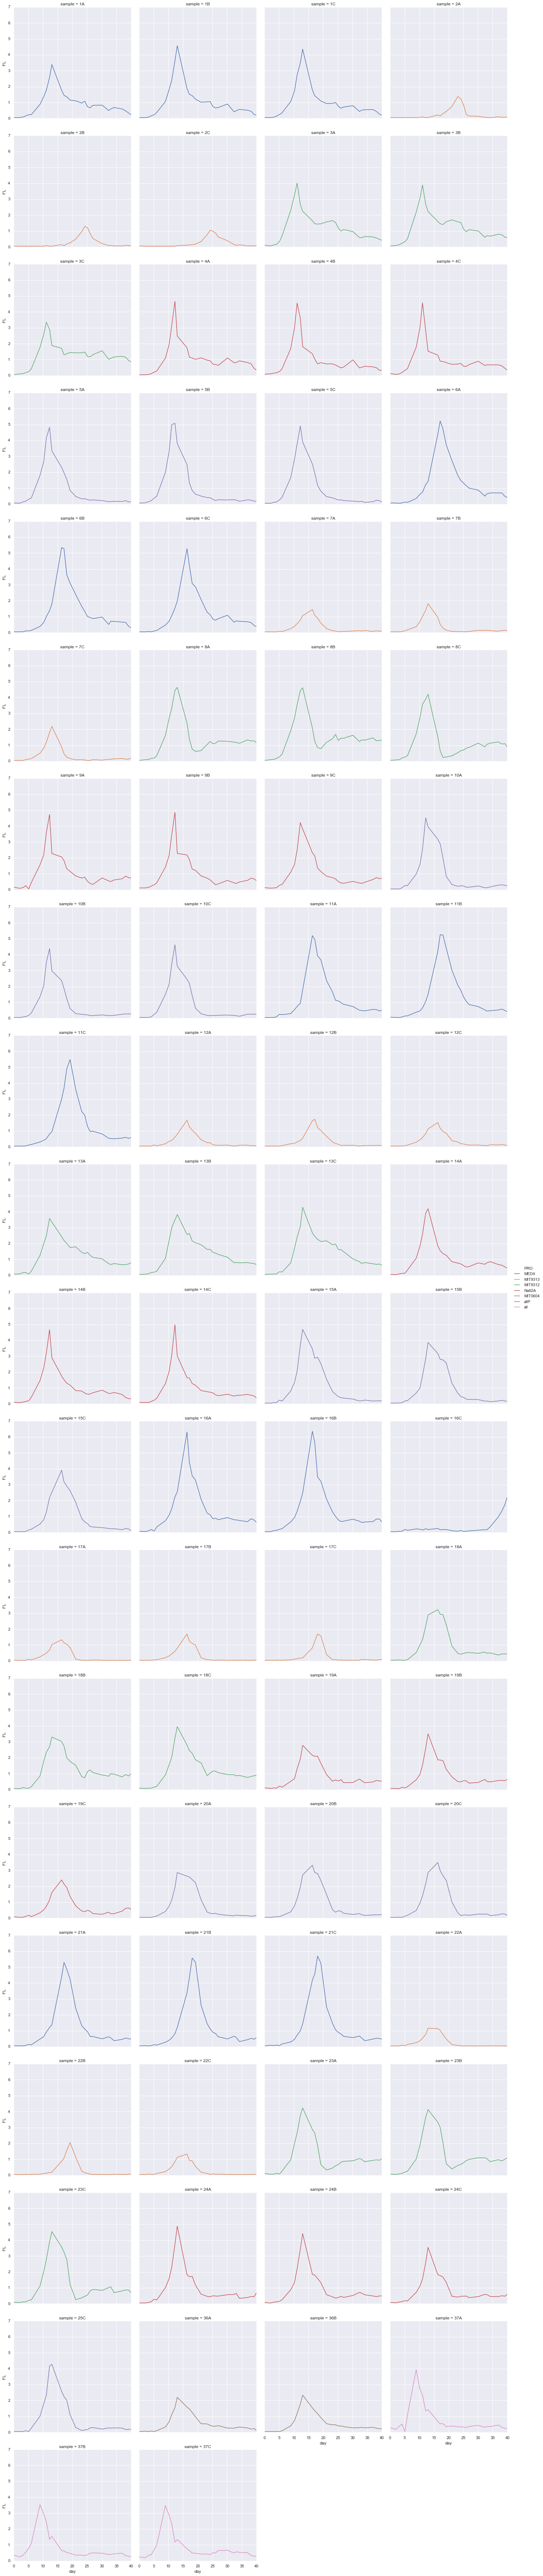

In [77]:
sns.relplot(data=df.loc[df.experiment == 'e2'], x='day', y='FL', 
            col='sample', hue='PRO', col_wrap=4, kind='line')

In [78]:
sns.catplot(data=lagsdf.loc[lagsdf.experiment == 'e1'],
            x='culture', y='coef', kind='box',
           )

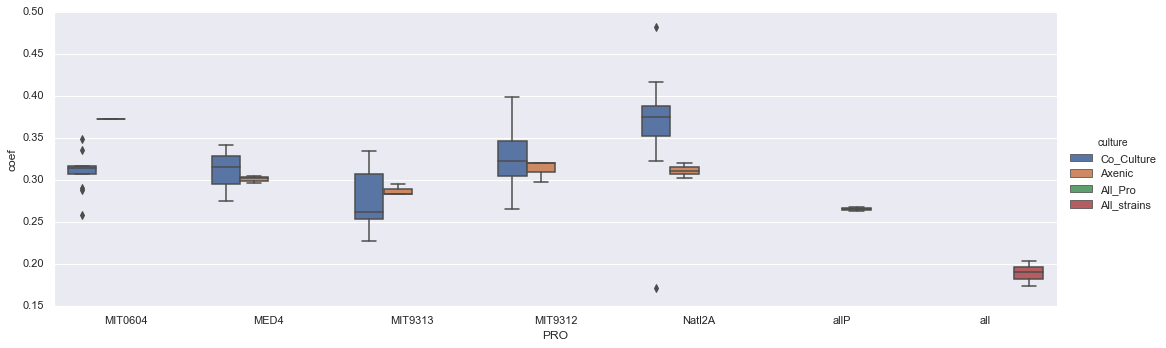

In [79]:
sns.catplot(data=lagsdf.loc[lagsdf.experiment == 'e1'],
            hue='culture', y='coef', kind='box', x='PRO', aspect=3,
           )